# Entraînement, validation et test : GEC, analyse multivariée, ...

Import some libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import statistics
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test

from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

### Train : with dataset TCGA-LIHC

In [4]:
# import data 

# les 109 gènes retenus dans l'étape de croisement entre les datasets pour les gènes fréquemment activés
specific_gene = pd.read_csv("gene_symbol.csv", sep=';', header = None) 

# expression data
expression_data_TCGA_LIHC = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_tcga_lihc_TCGA-LIHC_log_fpkm_439_samples_43022_genes.csv", sep=";")

# on récupère les données dont les gènes sont présents dans 109 gènes 
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'].isin(specific_gene[0].values)]

# clinic data
clinic_data_TCGA_LIHC = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_TCGA-LIHC.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
#print some data
clinic_data_TCGA_LIHC.head(3)

id_sample main_gse_number id_platform      organism  \
0  TCGA-G3-A3CG-01A       TCGA-LIHC       multi  Homo sapiens   
1  TCGA-DD-AAVP-01A       TCGA-LIHC       multi  Homo sapiens   
2  TCGA-FV-A3R3-01A       TCGA-LIHC       multi  Homo sapiens   

                           sample_title  sample_source sex  \
0  d02deece-d8bc-4614-ac26-60a4282fdb07  Primary Tumor   M   
1  9259e9ee-7279-4b62-8512-509cb705029c  Primary Tumor   M   
2  8abda02f-aedf-4599-9407-e253207d5d4c  Primary Tumor   F   

             ethnic_group  age_min  age_max  ...  relapsed   dead  treatment  \
0  not hispanic or latino    80.64    80.64  ...      True  False        NaN   
1  not hispanic or latino    48.86    48.86  ...      True  False        NaN   
2  not hispanic or latino    38.99    38.99  ...     False   True        NaN   

  exposure    id_patient tissue_group_level1 tissue_group_level2  \
0      NaN  TCGA-G3-A3CG               liver       hepato_bilary   
1      NaN  TCGA-DD-AAVP               liver       hepato_bilary   
2      NaN  TCGA-FV-A3R3               liver       hepato_bilary   

  tissue_group_level3 os_censor dfs_censor  
0                soma       0.0        1.0  
1                soma       0.0        1.0  
2                soma       1.0        1.0  

[3 rows x 42 columns]

In [5]:
# print some expression data
expression_data_TCGA_LIHC.head(3)

id_gene gene_symbol  TCGA-2V-A95S-01A  TCGA-2Y-A9GS-01A  \
34         41       ASIC1          0.092072          0.566474   
270       343        AQP8          0.072037          0.064331   
1241     1594     CYP27B1          0.582267          0.124196   

      TCGA-2Y-A9GT-01A  TCGA-2Y-A9GU-01A  TCGA-2Y-A9GV-01A  TCGA-2Y-A9GW-01A  \
34            0.037593          0.072037          0.022048          0.181166   
270           3.402886          1.303284          1.324868          2.172872   
1241          0.726744          0.133695          0.215616          1.823219   

      TCGA-2Y-A9GX-01A  TCGA-2Y-A9GY-01A  ...  TCGA-ZP-A9CZ-01A  \
34            0.164143          1.046421  ...          0.146395   
270           2.414623          0.114100  ...          0.135272   
1241          0.218099          0.452701  ...          0.151469   

      TCGA-ZP-A9D0-01A  TCGA-ZP-A9D1-01A  TCGA-ZP-A9D2-01A  TCGA-ZP-A9D4-01A  \
34            0.103531          0.088413          0.340391          0.273217   
270           2.184566          1.912037          0.037874          0.136323   
1241          0.176578          0.142217          0.761711          0.131853   

      TCGA-ZS-A9CD-01A  TCGA-ZS-A9CE-01A  TCGA-ZS-A9CF-01A  TCGA-ZS-A9CF-02A  \
34            0.043484          0.015498          0.012354          0.071900   
270           1.777072          0.641176          2.615463          0.573956   
1241          0.096127          0.338795          1.641962          1.703101   

      TCGA-ZS-A9CG-01A  
34            1.554392  
270           1.063848  
1241          0.153027  

[3 rows x 441 columns]

In [6]:
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.reset_index(drop=True)

In [7]:
expression_data_TCGA_LIHC.head()

id_gene gene_symbol  TCGA-2V-A95S-01A  TCGA-2Y-A9GS-01A  TCGA-2Y-A9GT-01A  \
0       41       ASIC1          0.092072          0.566474          0.037593   
1      343        AQP8          0.072037          0.064331          3.402886   
2     1594     CYP27B1          0.582267          0.124196          0.726744   
3     1811     SLC26A3          0.232538          0.035483          0.000000   
4     1828        DSG1          0.119555          2.889766          0.888772   

   TCGA-2Y-A9GU-01A  TCGA-2Y-A9GV-01A  TCGA-2Y-A9GW-01A  TCGA-2Y-A9GX-01A  \
0          0.072037          0.022048          0.181166          0.164143   
1          1.303284          1.324868          2.172872          2.414623   
2          0.133695          0.215616          1.823219          0.218099   
3          0.051442          0.263034          0.029559          0.195726   
4          1.397584          0.758388          0.609471          1.302933   

   TCGA-2Y-A9GY-01A  ...  TCGA-ZP-A9CZ-01A  TCGA-ZP-A9D0-01A  \
0          1.046421  ...          0.146395          0.103531   
1          0.114100  ...          0.135272          2.184566   
2          0.452701  ...          0.151469          0.176578   
3          0.455649  ...          0.403268          0.103934   
4          0.640436  ...          0.052277          2.527721   

   TCGA-ZP-A9D1-01A  TCGA-ZP-A9D2-01A  TCGA-ZP-A9D4-01A  TCGA-ZS-A9CD-01A  \
0          0.088413          0.340391          0.273217          0.043484   
1          1.912037          0.037874          0.136323          1.777072   
2          0.142217          0.761711          0.131853          0.096127   
3          0.802731          0.163241          0.033088          0.930775   
4          1.485169          0.346418          2.087938          0.554540   

   TCGA-ZS-A9CE-01A  TCGA-ZS-A9CF-01A  TCGA-ZS-A9CF-02A  TCGA-ZS-A9CG-01A  
0          0.015498          0.012354          0.071900          1.554392  
1          0.641176          2.615463          0.573956          1.063848  
2          0.338795          1.641962          1.703101          0.153027  
3          0.132774          0.360420          0.255440          0.672833  
4          0.726482          1.131589          1.697818          2.717188  

[5 rows x 441 columns]

In [5]:
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.dropna(subset=['os_months', 'os_censor'])

In [6]:
# Sélection des échantillons tumoraux
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC[clinic_data_TCGA_LIHC['tissue_status'] == "tumoral"]

In [7]:
# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_TCGA_LIHC['id_sample'].unique() if col in expression_data_TCGA_LIHC.columns]

# Sélection des données
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[['gene_symbol'] + selected_sample]

In [8]:
# Trouver les échantillons contenant des valeurs NaN dans expression_data_TCGA_LIHC
colonnes_avec_nan = expression_data_TCGA_LIHC.columns[expression_data_TCGA_LIHC.isna().any()].tolist()

In [9]:
# suppression des échantillons qui ont des valeurs manquantes(NAN)

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.dropna(axis=1) 
expression_data_TCGA_LIHC.head()

gene_symbol  TCGA-G3-A3CG-01A  TCGA-DD-AAVP-01A  TCGA-FV-A3R3-01A  \
34         ASIC1          0.174279          3.806107          0.310805   
270         AQP8          1.879078          5.055048          0.398460   
1241     CYP27B1          0.138421          1.955350          0.057831   
1390     SLC26A3          0.328607          1.705226          3.584024   
1407        DSG1          0.609944          0.684908          0.218347   

      TCGA-G3-A25Y-01A  TCGA-DD-AADU-01A  TCGA-BC-A10S-01A  TCGA-5R-AA1D-01A  \
34            0.730488          1.120949          0.029418          0.250598   
270           0.062398          0.384271          1.625645          0.703721   
1241          0.324350          0.246347          0.306846          0.205017   
1390          1.322332          0.314290          0.028569          3.823953   
1407          0.038296          2.524189          1.279174          0.054223   

      TCGA-G3-A25Z-01A  TCGA-DD-AAEH-01A  ...  TCGA-DD-AAE0-01A  \
34            0.019204          0.066537  ...          0.831796   
270           2.199657          2.869082  ...          0.056445   
1241          0.059771          0.032101  ...          0.590051   
1390          0.032524          0.120883  ...          0.023468   
1407          0.240620          1.410612  ...          0.123931   

      TCGA-FV-A4ZP-01A  TCGA-DD-A39V-01A  TCGA-DD-AAEK-01A  TCGA-DD-AAVX-01A  \
34            0.287945          1.615605          0.888071          0.051720   
270           0.184217          0.254594          0.624896          0.035905   
1241          0.364797          0.134615          0.242694          0.145743   
1390          0.110764          0.022616          0.366252          0.072586   
1407          0.010493          1.633478          2.044464          2.123037   

      TCGA-DD-A11A-01A  TCGA-ZP-A9CY-01A  TCGA-BC-A10R-01A  TCGA-QA-A7B7-01A  \
34            0.021338          0.069702          0.212134          0.035765   
270           2.449112          3.076371          3.454847          0.142479   
1241          0.150040          0.282499          0.088413          0.572502   
1390          0.028993          0.051024          0.142479          0.060186   
1407          1.126841          1.290483          1.914603          0.173255   

      TCGA-CC-5264-01A  
34            1.227864  
270           3.492110  
1241          0.785592  
1390          0.425567  
1407          0.129217  

[5 rows x 374 columns]

In [10]:
# id_sample en index dans clinic_data_TCGA_LIHC

clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.set_index('id_sample') 

In [11]:
# dans clinic_data_TCGA_LIHC, on suprrime les id_sample(ligne complète) qui ont des nan dans expression_data_TCGA_LIHC

clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.drop(colonnes_avec_nan)

In [12]:
clinic_data_TCGA_LIHC.shape

(373, 41)

In [13]:
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.reset_index() 

Seuils calculés par "ectopy" :

In [19]:
# import data(ectopy_adaptaive_threshold_percentile)

seuil_ectopy = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/TRAINING_Ectopy_python_significant_genes_TCGA-LIHC_FDR_1.0.xlsx")
#seuil_ectopy = seuil_ectopy.iloc[1:].reset_index(drop=True)
print(seuil_ectopy.shape)
seuil_ectopy.head(3)

(58, 10)


Gene threshold_name  threshold  threshold_percentile   p_value  \
0      APLN            T63   1.431588             51.107239  0.003155   
1     ASIC1            T26   0.482416             66.923592  0.023705   
2  ATP6V1E2           T109   0.847760             74.107239  0.004508   

   hazard_ratio  validated  cv_score  optimal       FDR  
0      1.704304       True        14     True  0.011771  
1      1.513679       True         2     True  0.051098  
2      1.715253       True        14     True  0.013664

In [37]:
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.dropna(subset=['os_months', 'os_censor'])

In [39]:
# Create DataFrame "data_cox" for results after Cox model and logrank test 
data_cox = pd.DataFrame(columns=['gene_symbol', 'pval_logrank', 'hazard_ratio'])

# survival data
time = clinic_data_TCGA_LIHC['os_months'].astype(float)   # temps
event = clinic_data_TCGA_LIHC['os_censor'].astype(float)  # censure

data_surv = pd.DataFrame({'duration': time, 'event': event})

Cox model and logrank test:

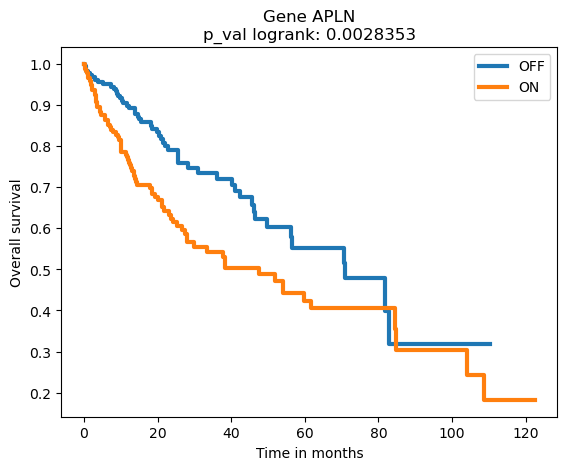

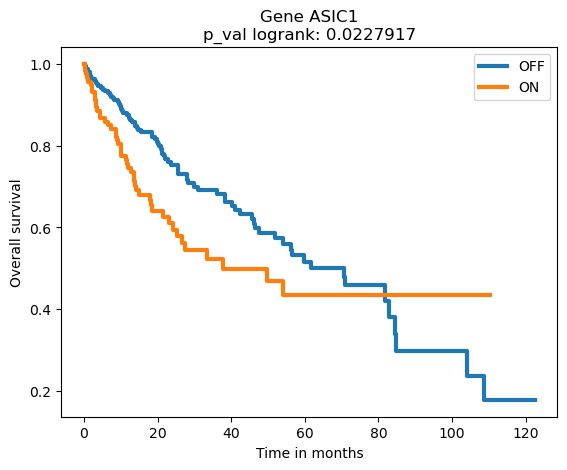

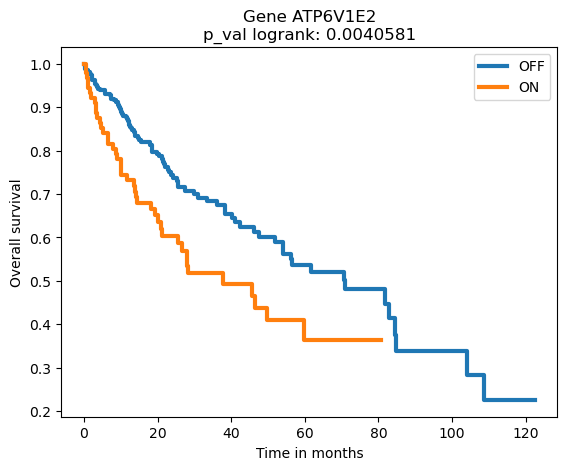

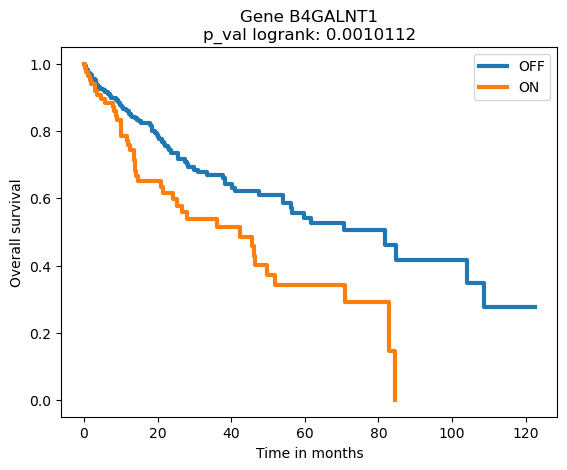

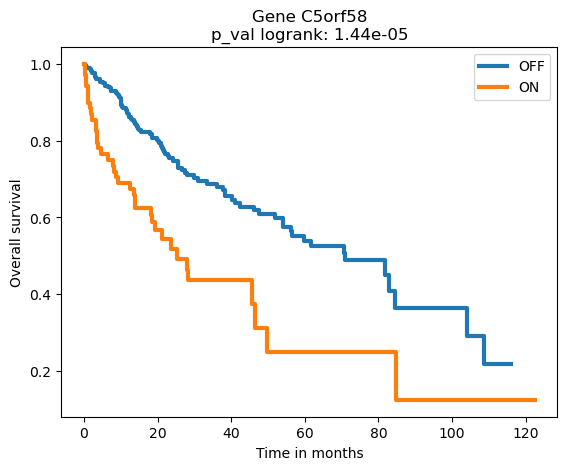

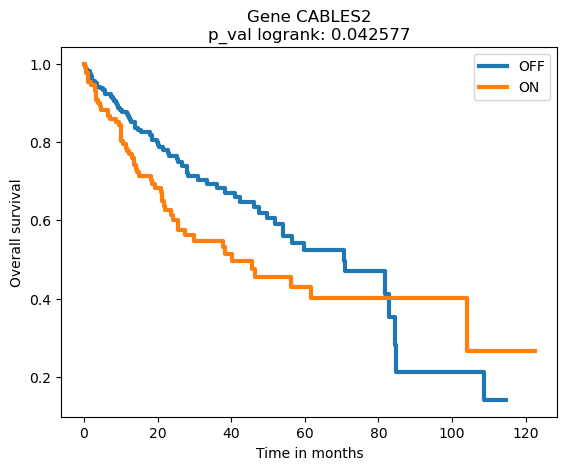

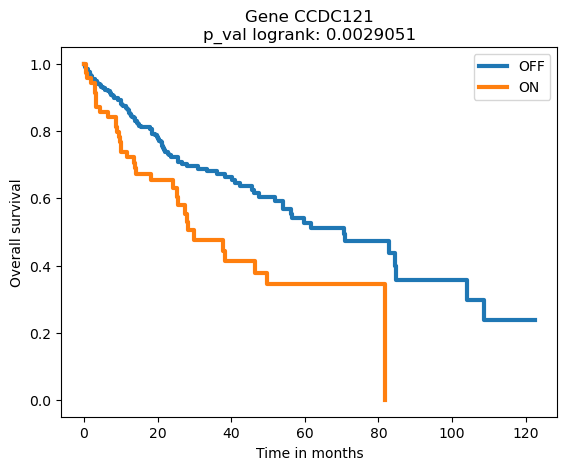

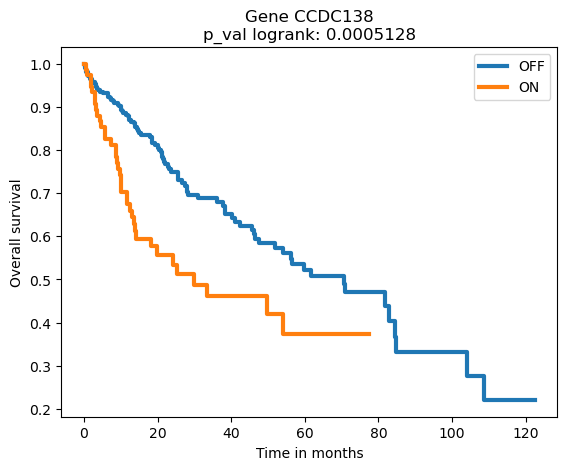

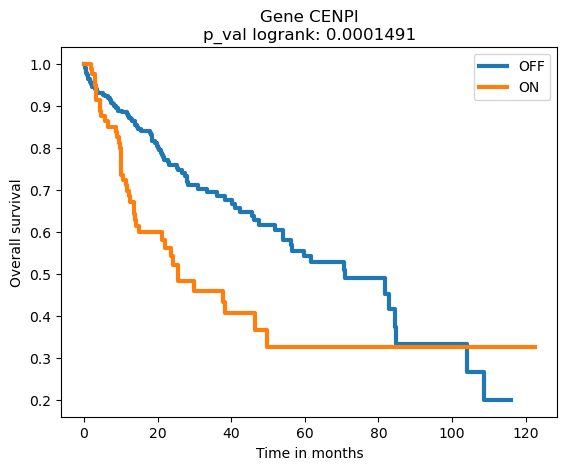

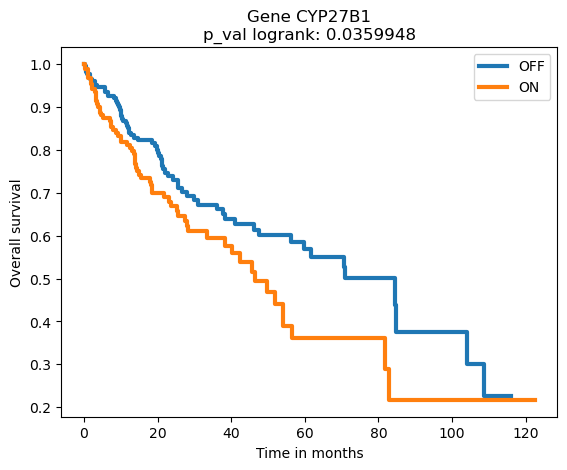

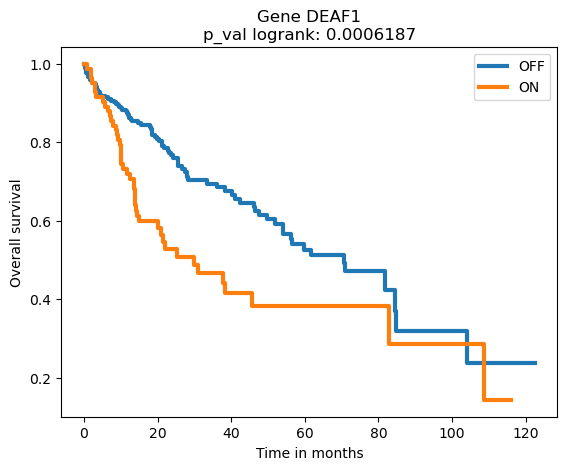

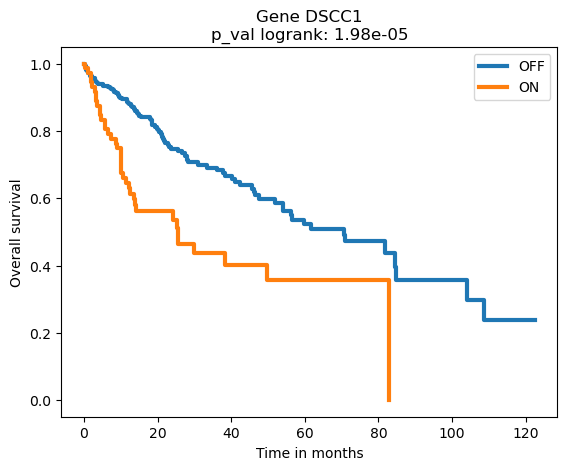

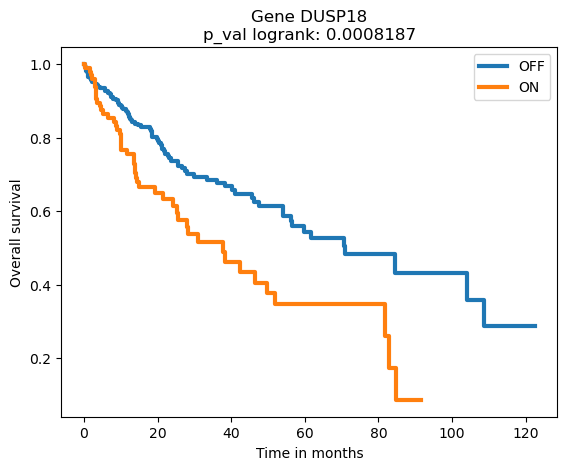

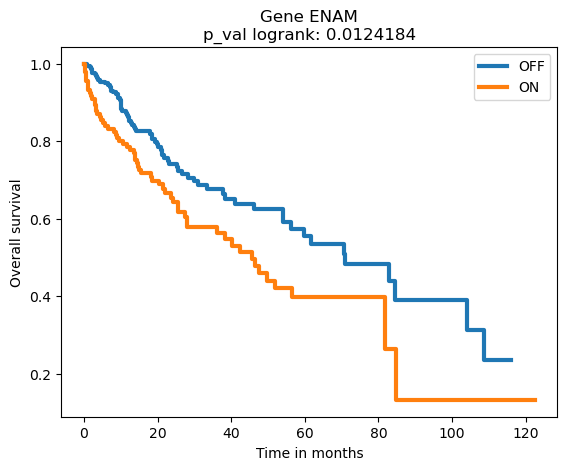

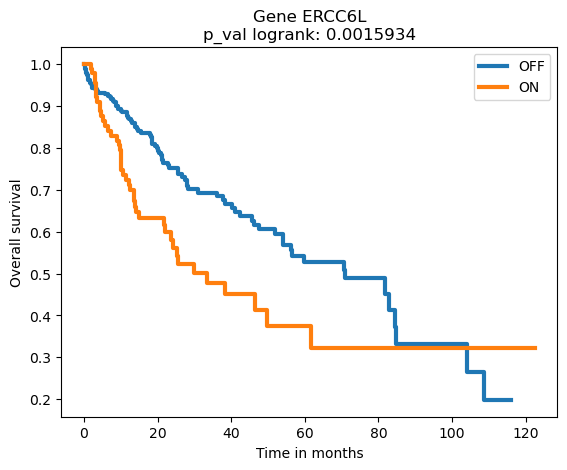

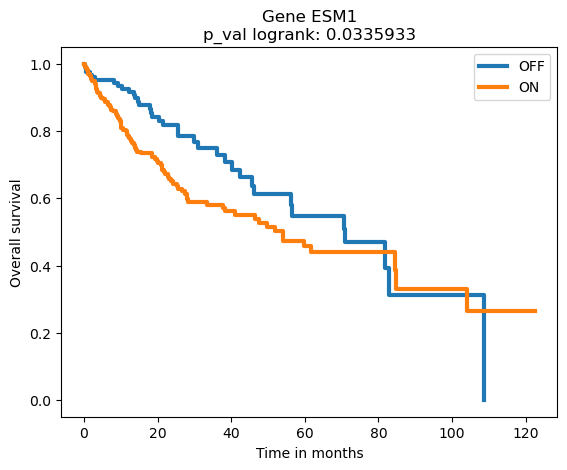

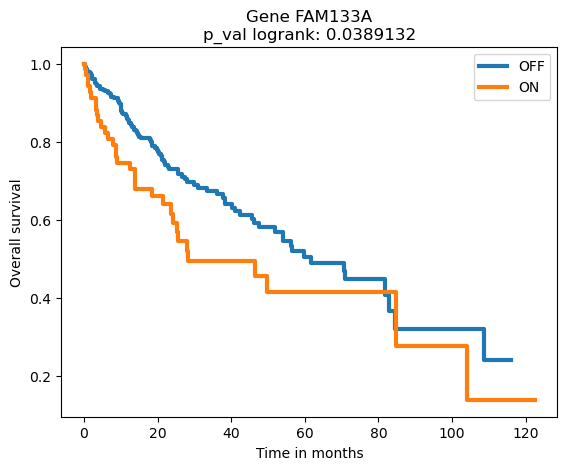

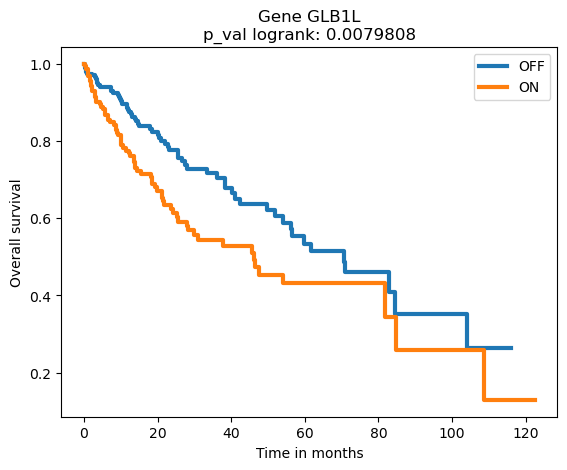

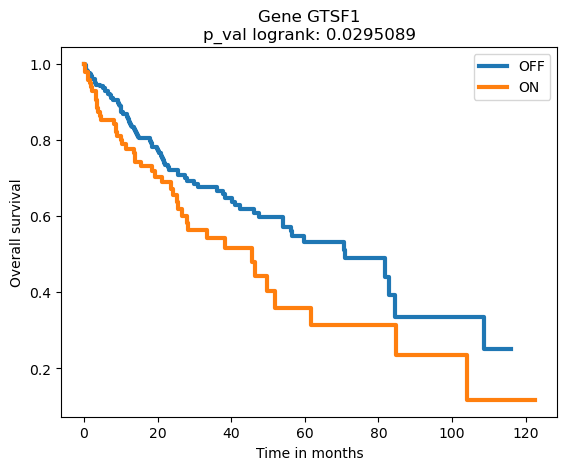

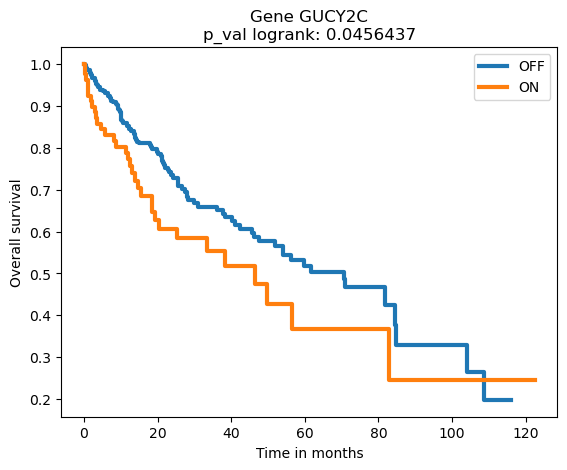

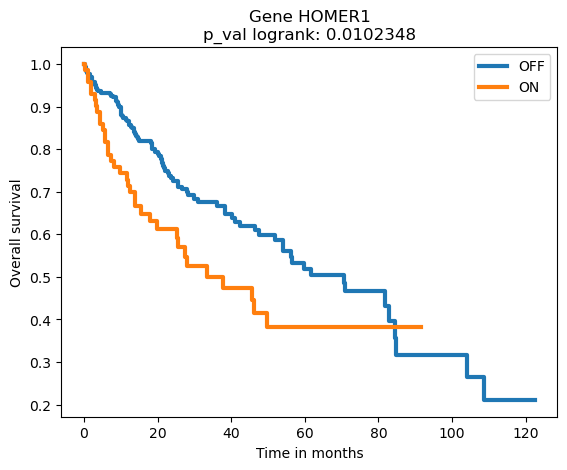

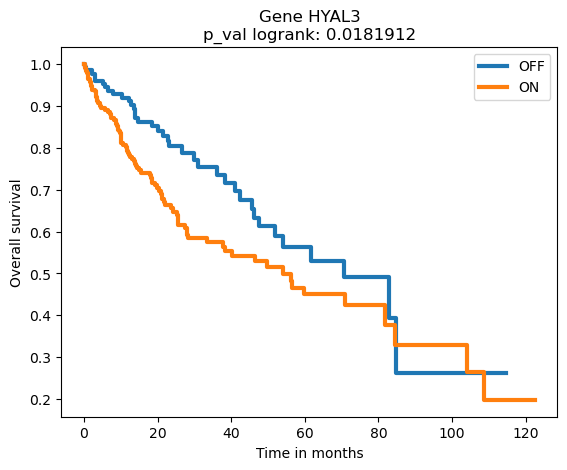

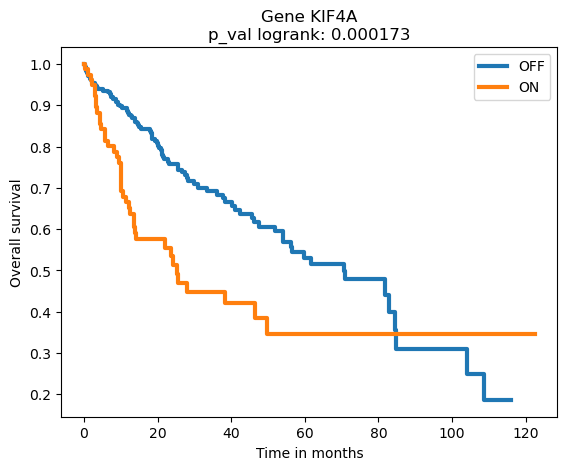

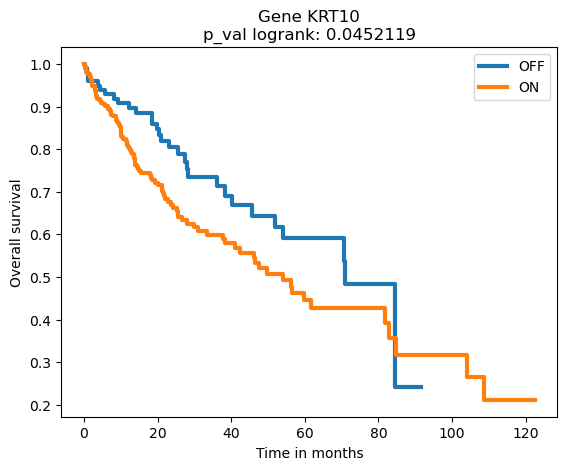

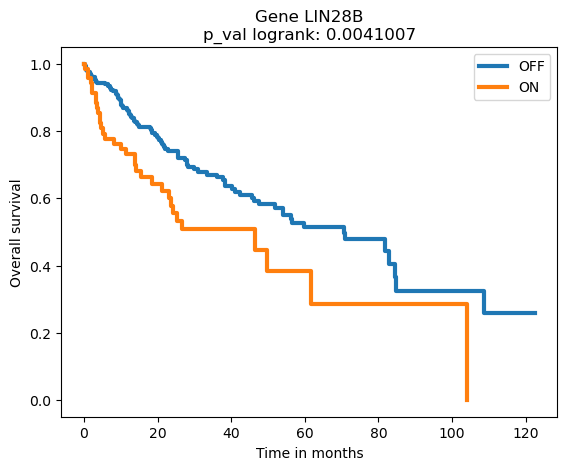

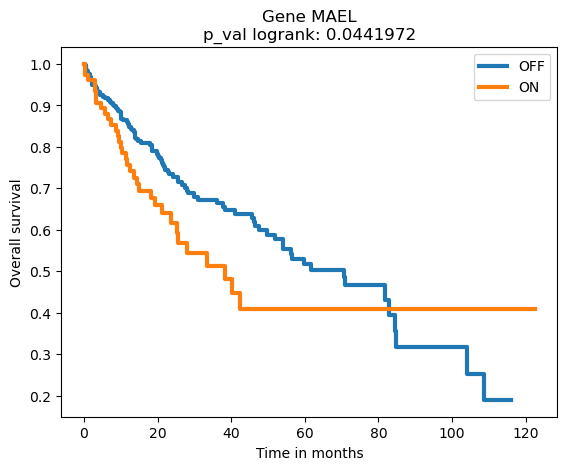

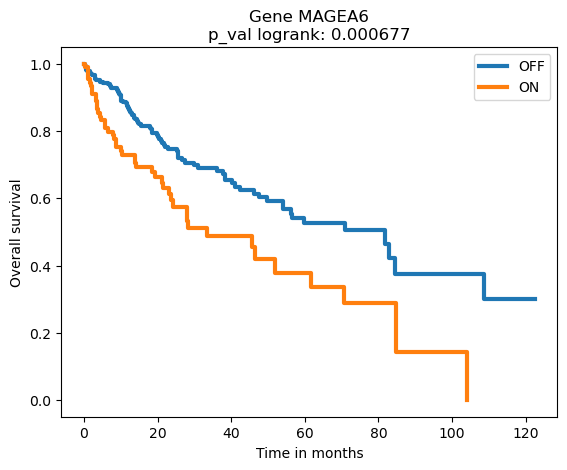

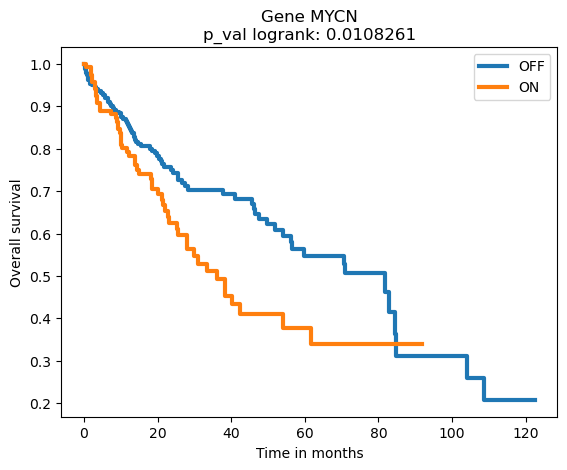

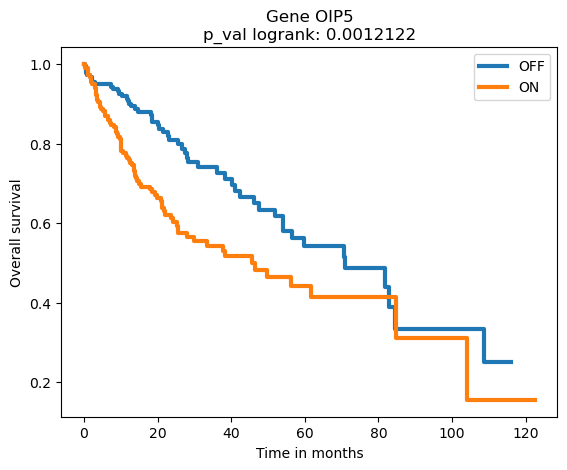

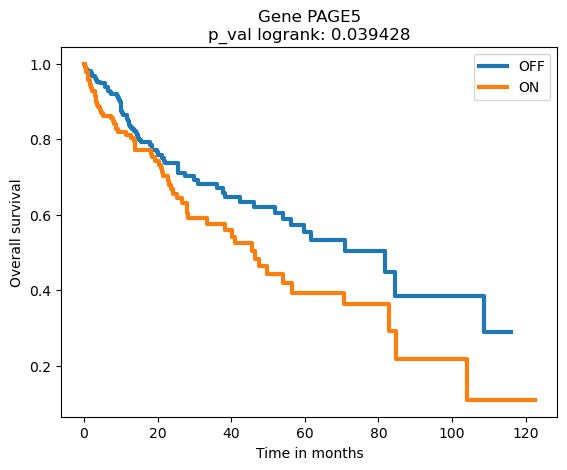

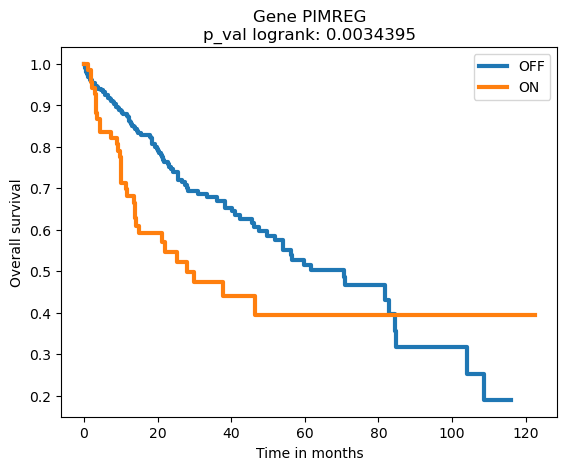

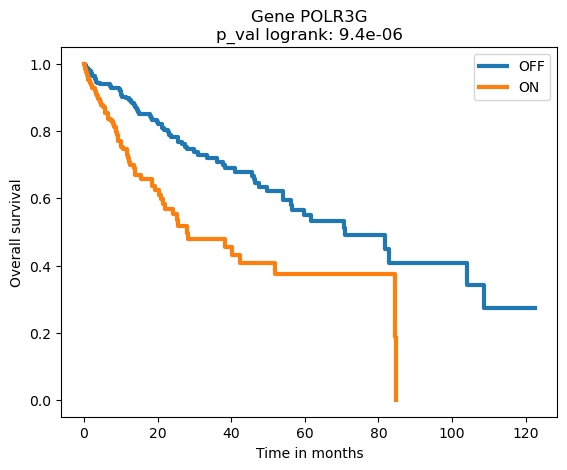

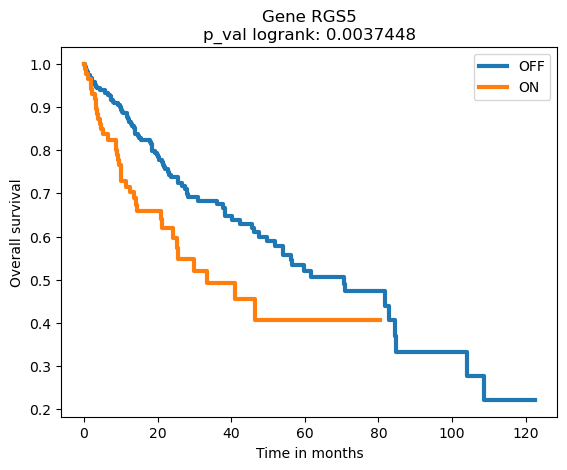

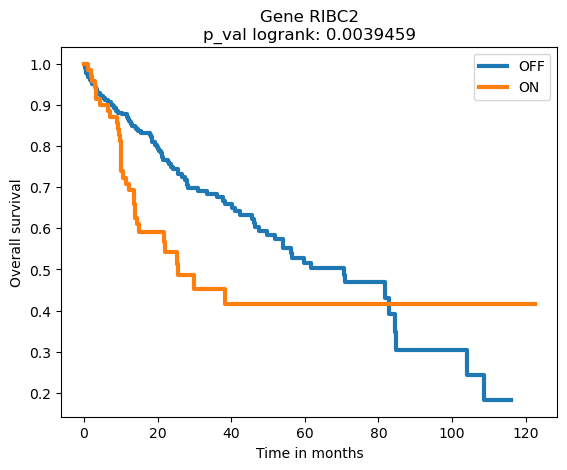

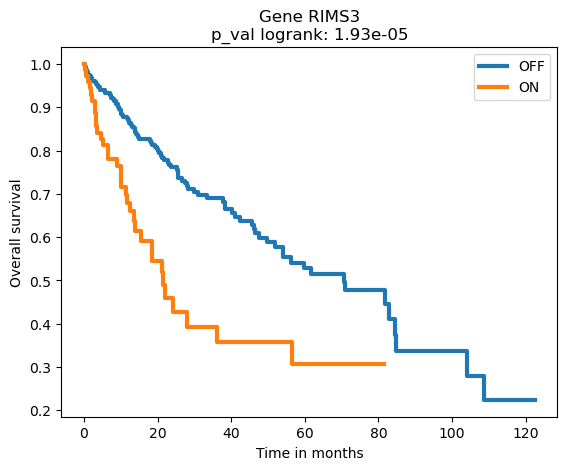

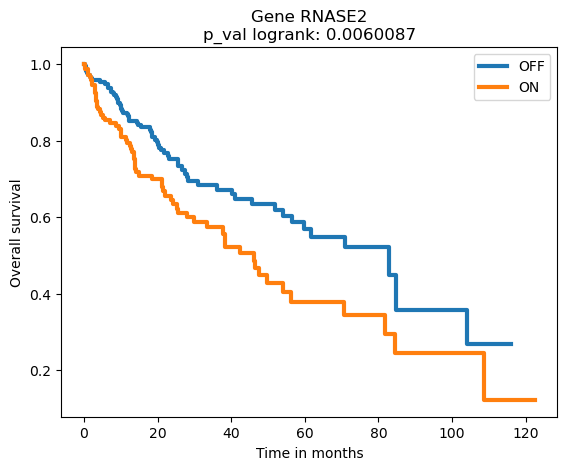

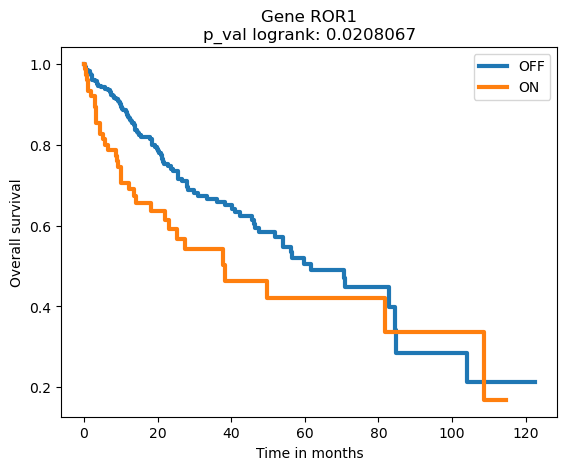

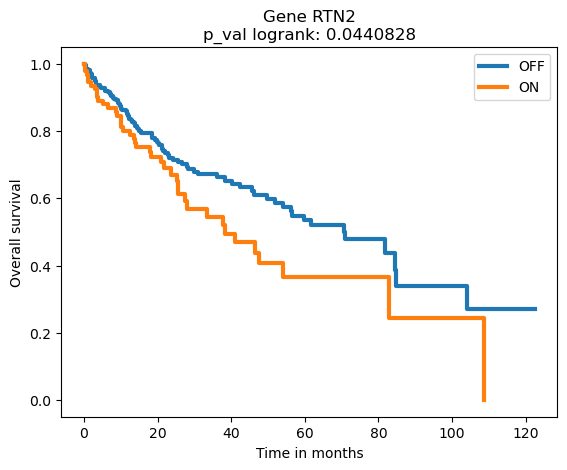

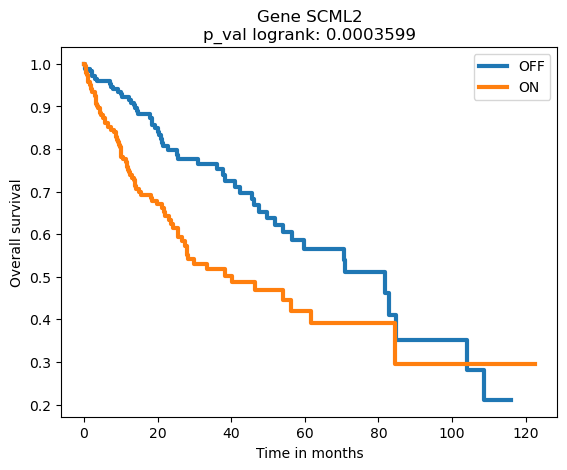

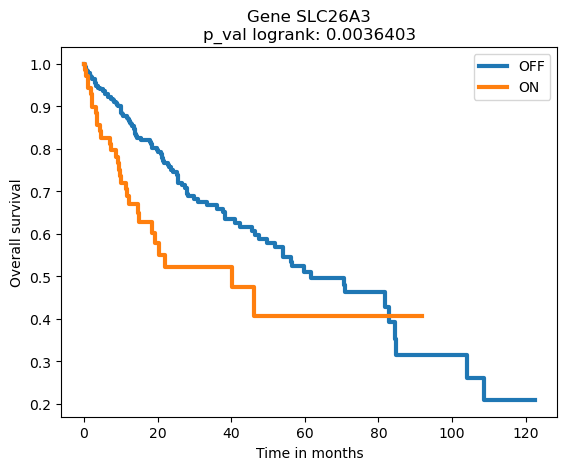

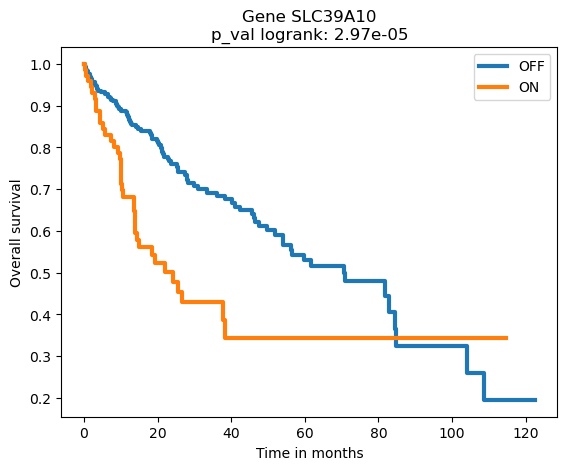

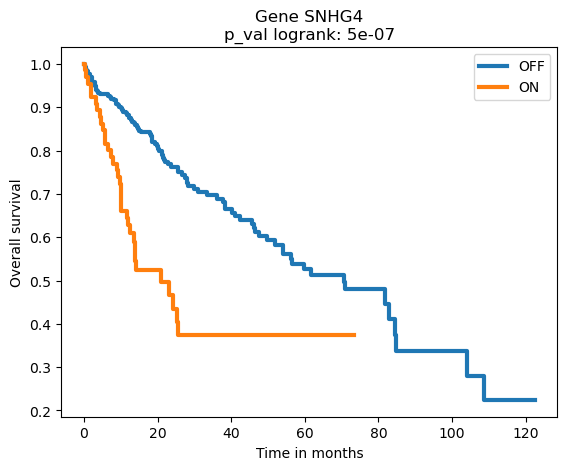

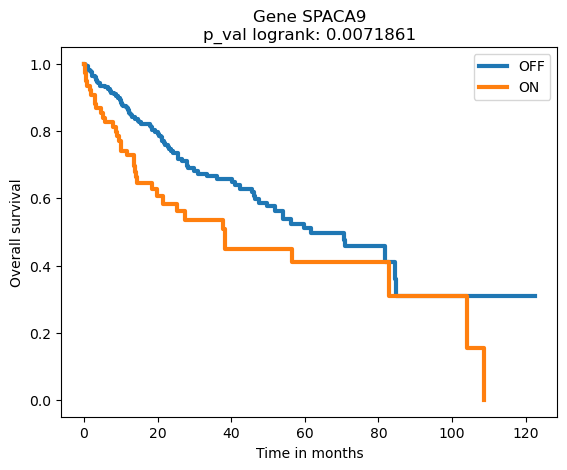

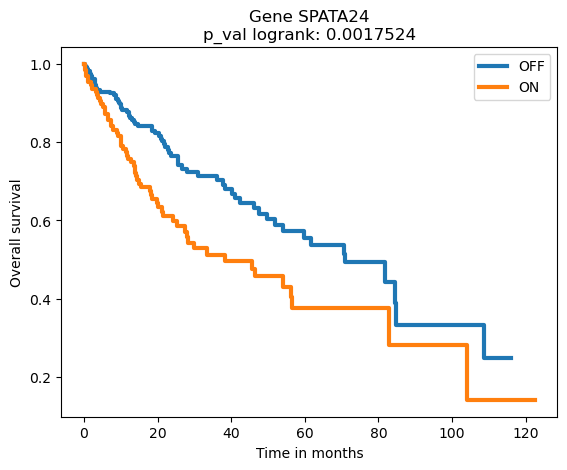

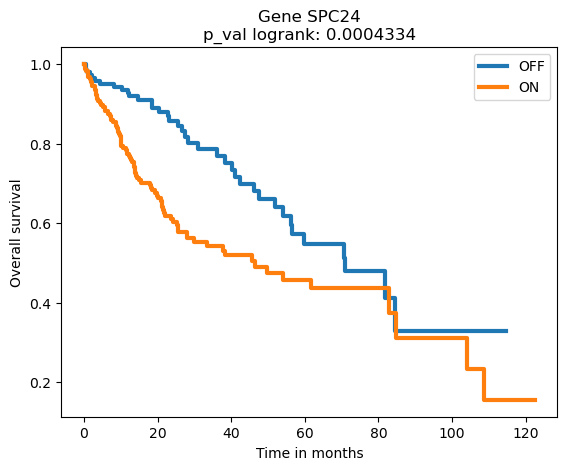

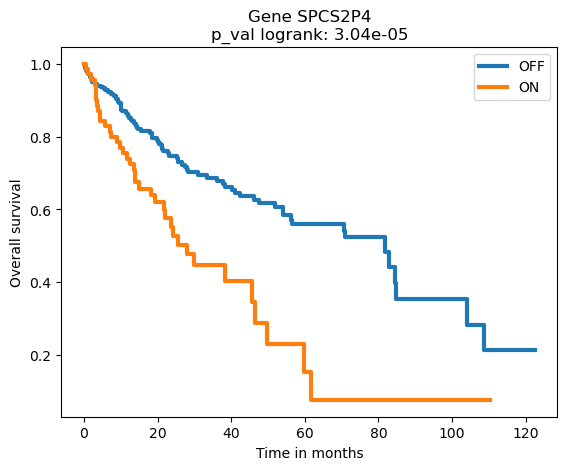

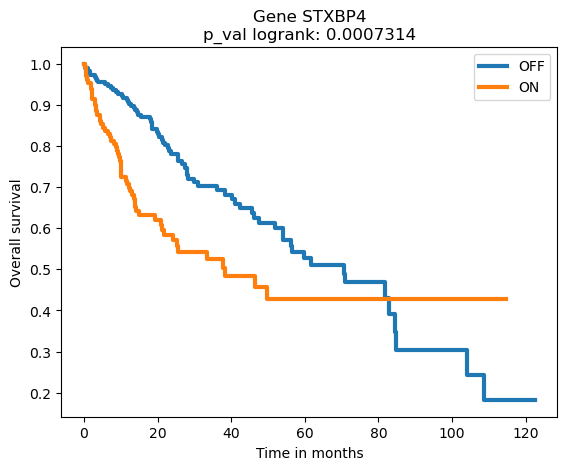

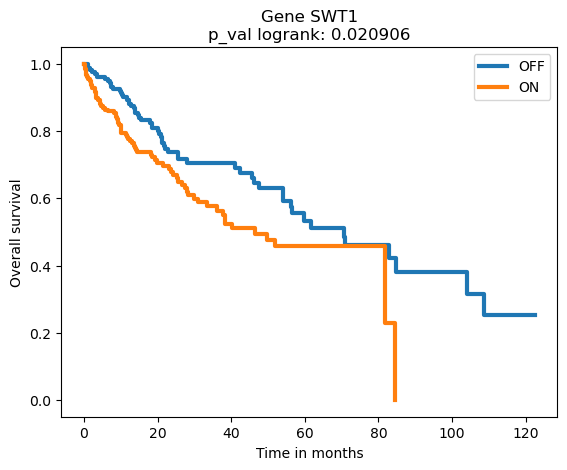

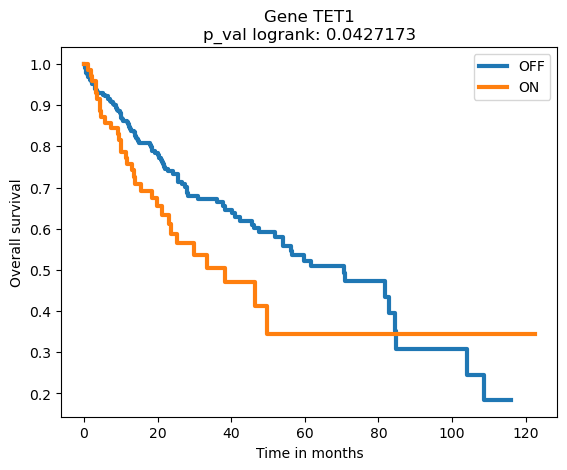

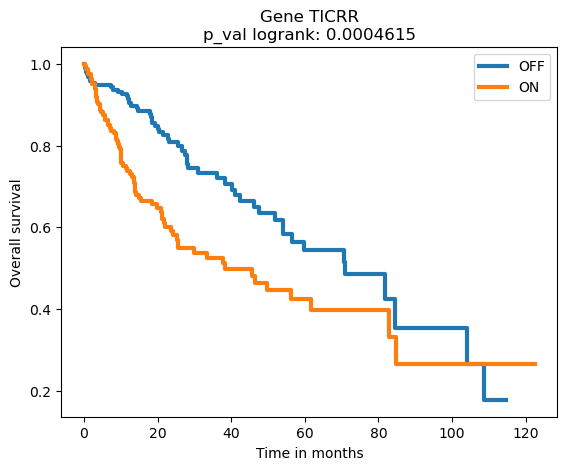

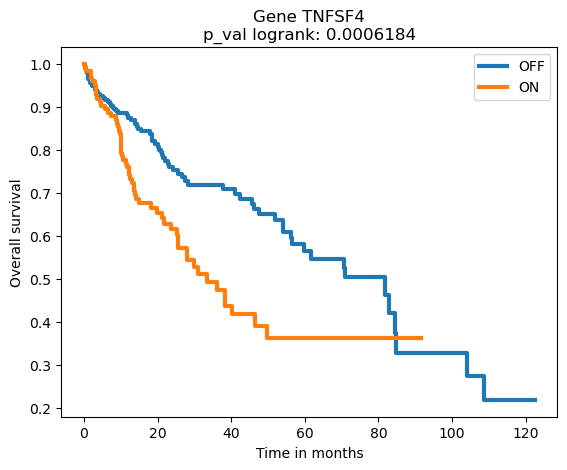

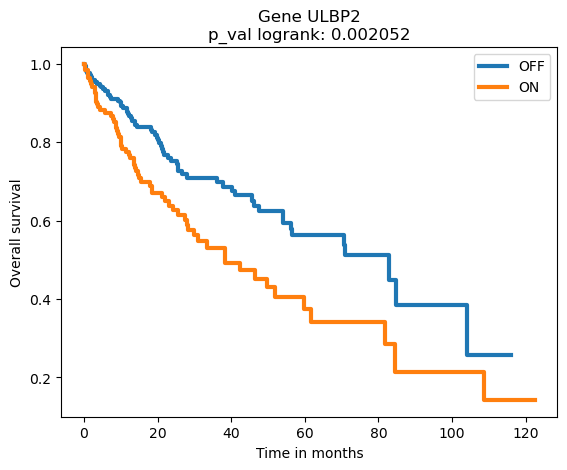

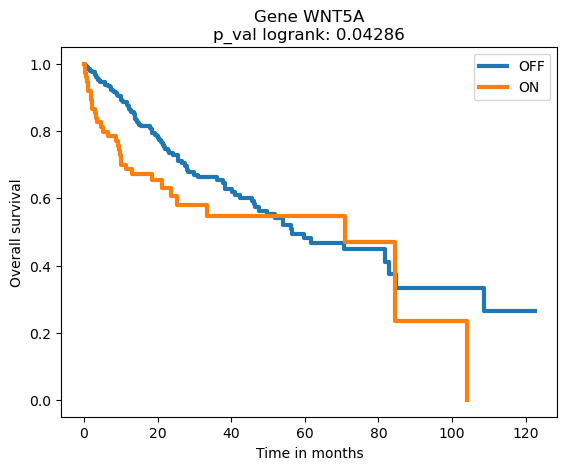

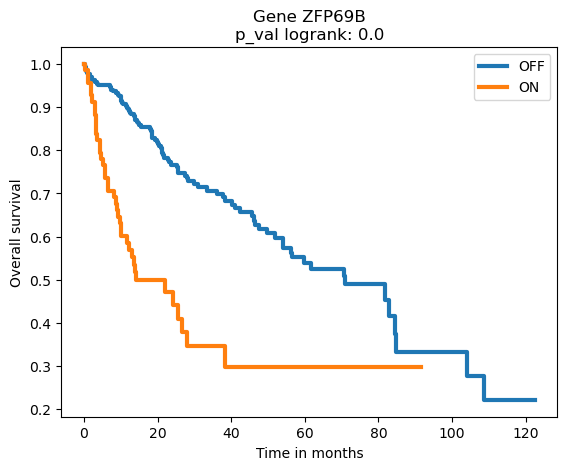

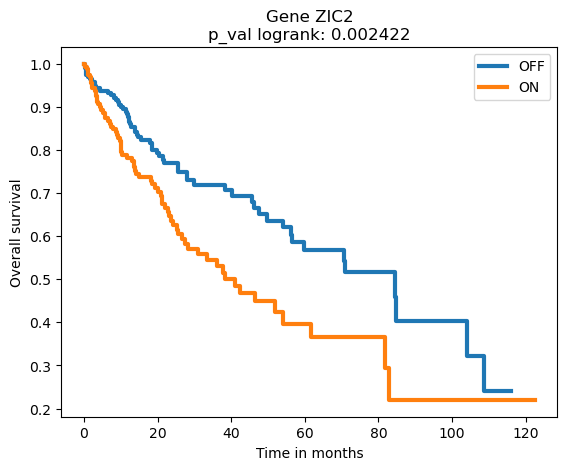

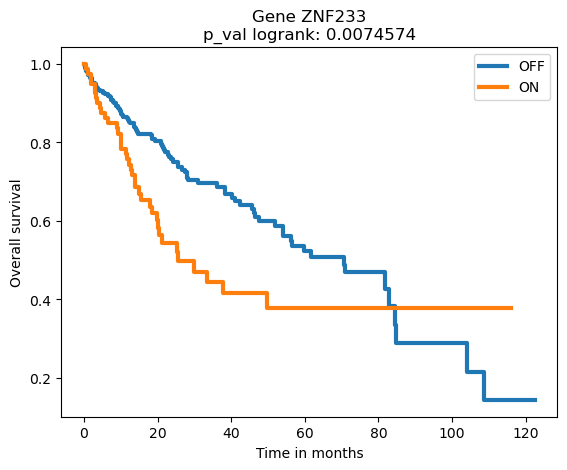

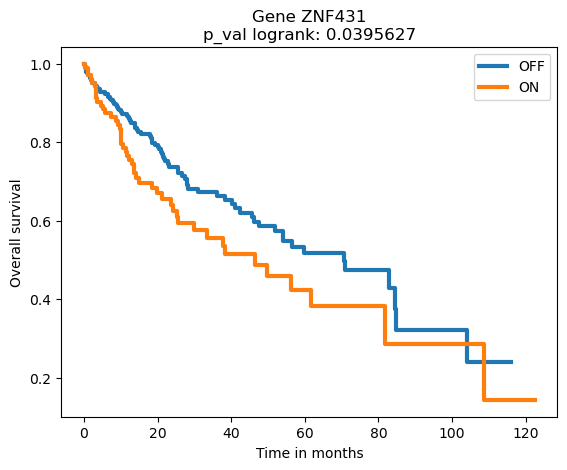

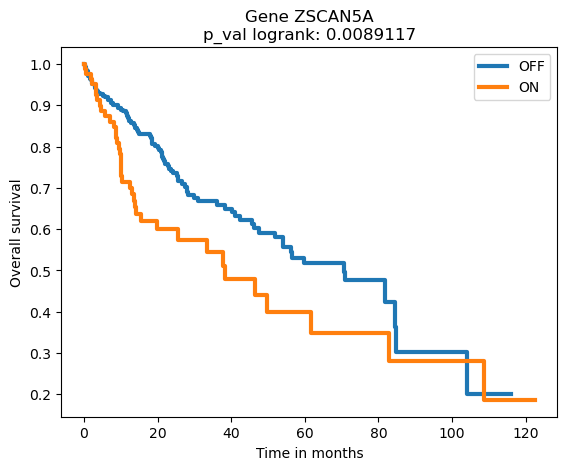

In [20]:
# Créer une instance de CoxPHFitter
coxph = CoxPHFitter()

# Boucle sur chaque ligne de seuil_ectopy
for i in range(len(seuil_ectopy)):
    
    # Récupération d'un gène
    gene_symbol = seuil_ectopy['Gene'].iloc[i]
    
    # ajout du gene dans data_cox
    data_cox.loc[i, 'gene_symbol'] = gene_symbol
    
    # Sélectionner les données d'expression du gène
    gene_data = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'] == gene_symbol].drop(columns=['gene_symbol'])
    
    # Vérifiez si gene_data est vide
    if gene_data.empty:
        print(f"No data found for gene {gene_symbol}")
        continue

    # Créer un DataFrame à partir de gene_data
    df = pd.DataFrame(gene_data.values.T, columns=[gene_symbol])

    # Sélectionner uniquement la colonne du gène actuel pour le modèle de Cox
    X = pd.concat([data_surv.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
    X = X.dropna()  # Suppression des lignes de X contenant des NAN

    # Fit le modèle de Cox
    #val_cox = coxph.fit(X, duration_col='duration', event_col='event')
    # ajout dans data_cox
    #data_cox.loc[i, 'pval_cox'] = round(val_cox.summary.loc[gene_symbol, 'p'], 7)

    # Binarisation des données d'expression en utilisant le seuil calculé par ectopy
    seuil = seuil_ectopy['threshold_percentile'].iloc[i] / 100
    expression_bin = (gene_data.values.flatten() > np.quantile(gene_data.values.flatten(), seuil)).astype(int)
    
    # Vérifier qu'il y a bien deux groupes
    if len(np.unique(expression_bin)) != 1:
        
        # Log-rank test
        
        # creer deux groupes(0 pour les échantillons OFF et 1 pour ON)
        groups = pd.Series(expression_bin)
        ix = (groups == 0)
        
        kmf_low = KaplanMeierFitter()
        kmf_high = KaplanMeierFitter()
        
        kmf_low.fit(time[ix], event_observed=event[ix], label='OFF')
        kmf_high.fit(time[~ix], event_observed=event[~ix], label='ON')
        
        log_rank_result = statistics.logrank_test(time[ix], time[~ix], event_observed_A=event[ix], event_observed_B=event[~ix])
        
        #logrank_result = multivariate_logrank_test(temps, groups, censure)
        #logrank_p_value = logrank_results.p_value
        
        # ajout dans data_cox de la valeur de pval_logrank 
        data_cox.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        ax = kmf_low.plot_survival_function(ci_show=False,linewidth=3)
        kmf_high.plot_survival_function(ax=ax, ci_show=False,linewidth=3)
        
        ## Ajout de la légende et du titre
        ax.set_title(f'Gene {gene_symbol}\np_val logrank: {data_cox.loc[i, "pval_logrank"]}')
        ax.set_xlabel('Time in months')
        ax.set_ylabel('Overall survival')
        
        plt.show()
        
        # ajout dans data_cox de la valeur de pval_logrank 
        #data_cox.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        # Ajuster un modèle de Cox binaire pour le hazard ratio
        coxph.fit(pd.concat([time, event, pd.Series(expression_bin, name='expression_bin')], axis=1), duration_col='os_months', event_col='os_censor')
        
        # ajout de la valeur de hazard_ratio dans data_cox
        data_cox.loc[i, 'hazard_ratio'] = coxph.hazard_ratios_['expression_bin']


In [71]:
seuil_ectopy

Gene threshold_name  threshold  threshold_percentile   p_value  \
0      APLN            T63   1.431588             51.107239  0.003155   
5   CABLES2            T87   1.823764             63.107239  0.043737   
15     ESM1            T31   1.422932             35.107239  0.034770   
20   HOMER1           T100   1.102134             79.526810  0.011015   
21    HYAL3            T30   1.290205             34.875335  0.019184   
26   MAGEA6            T10   0.986766             73.668901  0.000814   
35   RNASE2             T1   0.299005             59.249330  0.006486   
45  SPCS2P4           T120   1.401418             79.607239  0.000048   

    hazard_ratio  validated  cv_score  optimal       FDR  
0       1.704304       True        14     True  0.011771  
5       1.429653       True         0     True  0.081586  
15      1.513450       True         0     True  0.071760  
20      1.657403       True         8     True  0.027396  
21      1.578069       True         2     True  0.044307  
26      1.858855       True        34     True  0.004644  
35      1.614065       True         8     True  0.018504  
45      2.213298       True        42     True  0.000578

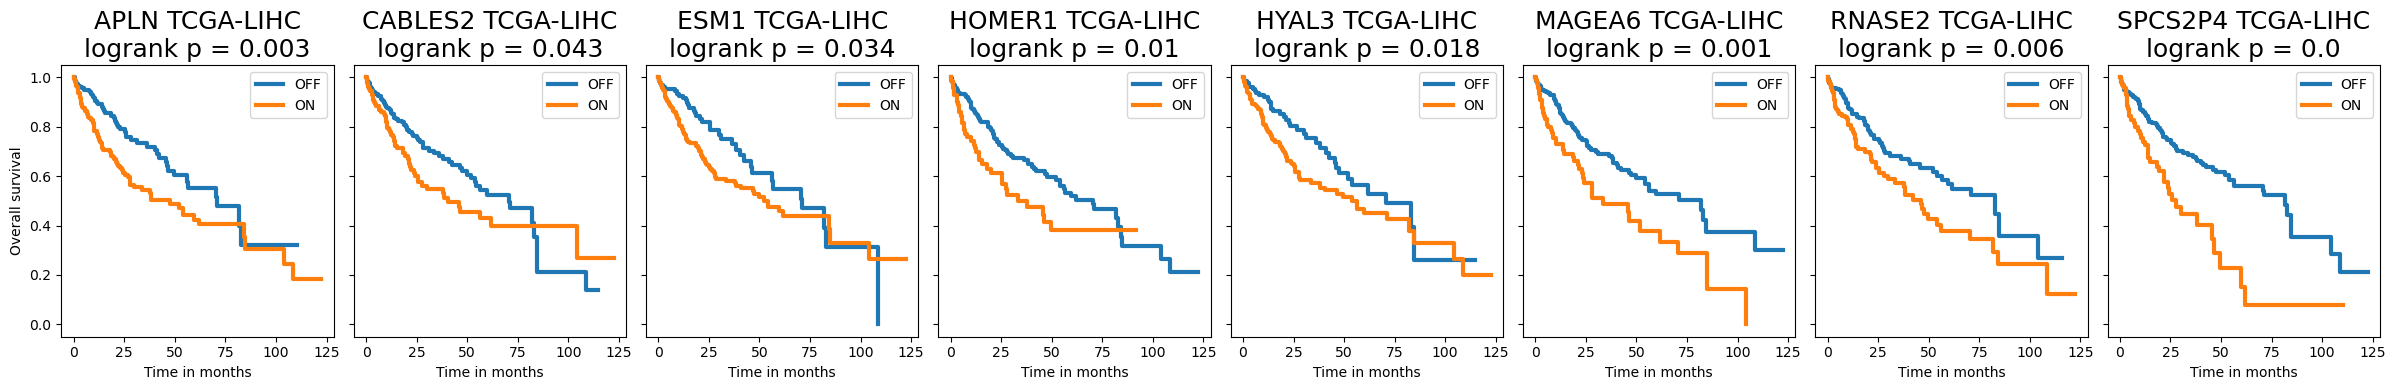

In [41]:
# Create a CoxPHFitter instance
coxph = CoxPHFitter()

# Prepare the data_cox DataFrame
data_cox = pd.DataFrame(columns=['gene_symbol', 'pval_logrank', 'hazard_ratio'])

# Set up the plotting figure
fig, axes = plt.subplots(1, 8, figsize=(24, 4), sharey=True)

seuil_ectopy = seuil_ectopy[seuil_ectopy['Gene'].isin(['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6'])]

# Loop over each gene
for i in range(len(seuil_ectopy)):
    # Get the gene symbol
    gene_symbol = seuil_ectopy['Gene'].iloc[i]
    
    #if gene in ['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6']:
        
        #gene_symbol=gene
    
    # Select the gene expression data
    gene_data = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'] == gene_symbol].drop(columns=['gene_symbol'])
    
    # Check if gene_data is empty
    if gene_data.empty:
        print(f"No data found for gene {gene_symbol}")
        continue

    # Create a DataFrame from gene_data
    df = pd.DataFrame(gene_data.values.T, columns=[gene_symbol])

    # Combine the base data with gene expression data
    X = pd.concat([base.reset_index(drop=True), df.reset_index(drop=True)], axis=1).dropna()

    # Binarize the gene expression data
    seuil = seuil_ectopy['threshold_percentile'].iloc[i] / 100
    expression_bin = (gene_data.values.flatten() > np.quantile(gene_data.values.flatten(), seuil)).astype(int)
    
    # Check for two groups
    if len(np.unique(expression_bin)) != 1:
        # Log-rank test
        groups = pd.Series(expression_bin)
        ix = (groups == 0)
        
        kmf_low = KaplanMeierFitter()
        kmf_high = KaplanMeierFitter()
        
        kmf_low.fit(shifted_time[ix], event_observed=shifted_event[ix], label='OFF')
        kmf_high.fit(shifted_time[~ix], event_observed=shifted_event[~ix], label='ON')
        
        log_rank_result = logrank_test(shifted_time[ix], shifted_time[~ix], event_observed_A=shifted_event[ix], event_observed_B=shifted_event[~ix])
        
        # Add logrank p-value to data_cox
        data_cox.loc[i, 'gene_symbol'] = gene_symbol
        data_cox.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        # Plot survival curves
        ax = axes[i]
        kmf_low.plot_survival_function(ax=ax, ci_show=False, linewidth=3)
        kmf_high.plot_survival_function(ax=ax, ci_show=False, linewidth=3)
        
        # Add legend and title
        ax.set_title(f'{gene_symbol} TCGA-LIHC\nlogrank p = {round(data_cox.loc[i, "pval_logrank"],3)}', fontsize=18)
        ax.set_xlabel('Time in months')
        if i == 0:
            ax.set_ylabel('Overall survival')
        
        # Fit Cox model to get hazard ratio
        coxph.fit(pd.concat([shifted_time, shifted_event, pd.Series(expression_bin, name='expression_bin')], axis=1), duration_col='os_months', event_col='os_censor')
        data_cox.loc[i, 'hazard_ratio'] = coxph.hazard_ratios_['expression_bin']

plt.tight_layout()
plt.show()

In [22]:
# Afficher le DataFrame résulatant
data_cox.head()

gene_symbol pval_logrank hazard_ratio
0        APLN     0.002835     1.704304
1     CABLES2     0.042577     1.429653
2        ESM1     0.033593      1.51345
3      HOMER1     0.010235     1.657403
4       HYAL3     0.018191     1.578069

In [23]:
tab = data_cox[["gene_symbol","pval_logrank"]]

In [24]:
tab.head()

gene_symbol pval_logrank
0        APLN     0.002835
1       ASIC1     0.022792
2    ATP6V1E2     0.004058
3    B4GALNT1     0.001011
4     C5orf58     0.000014

In [25]:
# save DataFrame into CSV file

data_cox.to_csv("tab1.csv", index=False, sep=";")

### Validation : with dataset GSE141202

In [20]:
# import data 

# les 109 gènes retenus dans l'étape de croisement entre les datasets pour les gènes fréquemment activés
specific_gene = pd.read_csv("gene_symbol.csv", sep=';', header = None) 

# expression data
expression_data_GSE141202 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE141202_log_rpkm_206_samples_38133_genes.csv", sep=";")

# on récupère les données dont les gènes sont présents dans 109 gènes 
expression_data_GSE141202 = expression_data_GSE141202[expression_data_GSE141202['gene_symbol'].isin(specific_gene[0].values)]

# clinic data
clinic_data_GSE141202 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.04.03_GSE141202.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [24]:
expression_data_GSE141202.head(3)

id_gene gene_symbol  GSM4196911  GSM4196912  GSM4196913  GSM4196914  \
32         41       ASIC1    0.576542    0.975458    0.000000    0.229222   
254       343        AQP8    0.258889    0.000000    0.896505    1.350615   
1182     1594     CYP27B1    0.920769    1.310073    0.775493    1.009241   

      GSM4196915  GSM4196916  GSM4196917  GSM4196918  ...  GSM4197113  \
32      0.984800    0.089874    0.050041    0.969739  ...    0.307798   
254     1.657373    0.000000    6.275501    1.046314  ...    0.110085   
1182    0.000000    0.388820    1.272263    0.596940  ...    0.710003   

      GSM4197114  GSM4197115  GSM4197116  GSM4197117  GSM4197118  GSM4197119  \
32      0.562058    0.100766    0.616988    0.087383    0.120325    2.421718   
254     0.000000    0.000000    0.000000    0.643494    0.000000    0.539822   
1182    1.017682    1.272470    1.844777    1.190347    0.420991    0.436002   

      GSM4197120  GSM4197121  GSM4197122  
32      1.075711    0.155513    0.568615  
254     0.221821    0.079870    0.376800  
1182    0.934098    0.739368    1.142740  

[3 rows x 208 columns]

In [25]:
clinic_data_GSE141202.head(3)

id_sample main_gse_number id_platform      organism sample_title  \
0  GSM4196911       GSE141202    GPL18573  Homo sapiens      TLCN002   
1  GSM4196912       GSE141202    GPL18573  Homo sapiens      TLCN003   
2  GSM4196913       GSE141202    GPL18573  Homo sapiens      TLCN004   

              sample_source  sex  ethnic_group  age_min  age_max  ...  \
0  Hepatocellular carcinoma  NaN           NaN      NaN      NaN  ...   
1  Hepatocellular carcinoma  NaN           NaN      NaN      NaN  ...   
2  Hepatocellular carcinoma  NaN           NaN      NaN      NaN  ...   

   os_months relapsed  dead treatment exposure tissue_group_level1  \
0     140.20     True  True       NaN      NaN               liver   
1      51.67     True  True       NaN      NaN               liver   
2      41.03     True  True       NaN      NaN               liver   

  tissue_group_level2 tissue_group_level3 os_censor dfs_censor  
0       hepato_bilary                soma         1          1  
1       hepato_bilary                soma         1          1  
2       hepato_bilary                soma         1          1  

[3 rows x 41 columns]

In [21]:
clinic_data_GSE141202 = clinic_data_GSE141202.dropna(subset=['os_months', 'os_censor'])

In [22]:
# Sélection des échantillons tumoraux
clinic_data_GSE141202 = clinic_data_GSE141202[clinic_data_GSE141202['tissue_status'] == "tumoral"]

In [23]:
# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE141202['id_sample'].unique() if col in expression_data_GSE141202.columns]

# Sélection des données
expression_data_GSE141202 = expression_data_GSE141202[['gene_symbol'] + selected_sample]

In [24]:
# Trouver les échantillons contenant des valeurs NaN dans expression_data_TCGA_LIHC
colonnes_avec_nan = expression_data_GSE141202.columns[expression_data_GSE141202.isna().any()].tolist()

print(colonnes_avec_nan)

[]


In [30]:
# Création du DataFrame data_cox_val( val : validation)
data_cox_val = pd.DataFrame(columns=['gene_symbol', 'pval_logrank', 'hazard_ratio'])

# données de survie
time = clinic_data_GSE141202['os_months'].astype(float)
event = clinic_data_GSE141202['os_censor'].astype(float)
data_surv = pd.DataFrame({'duration': time, 'event': event})

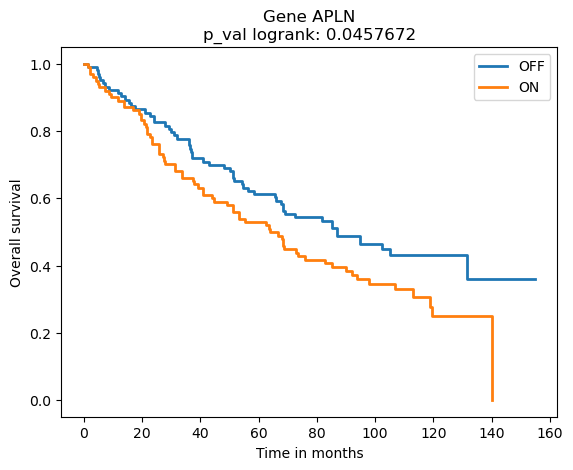

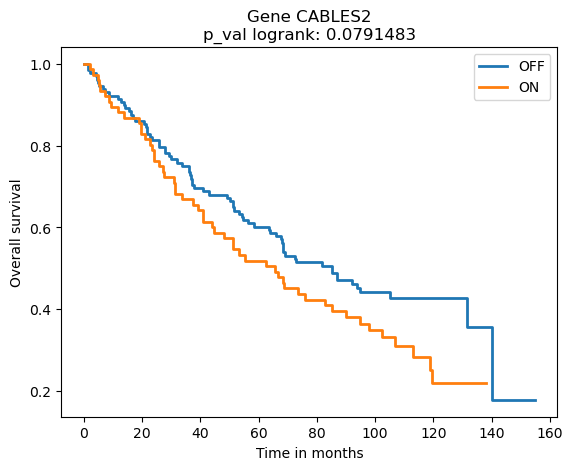

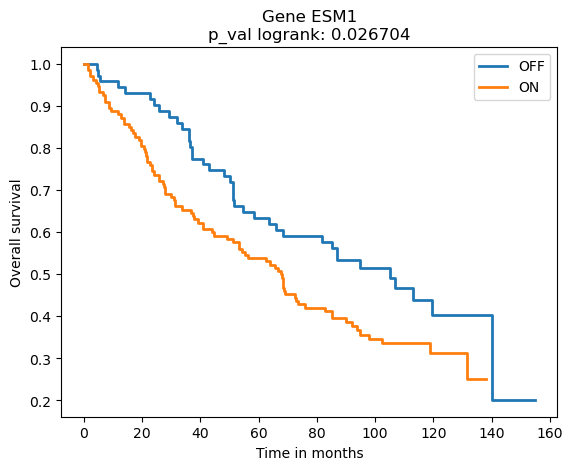

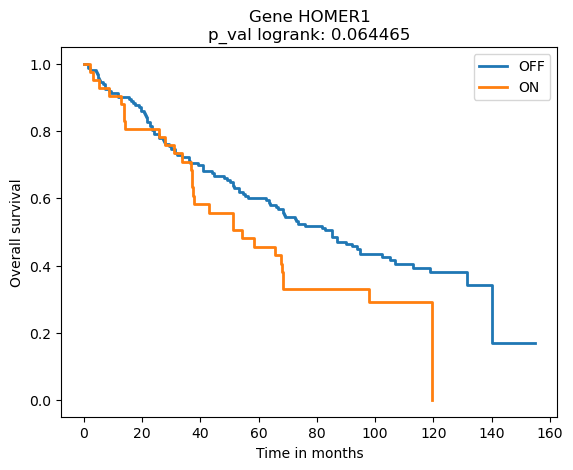

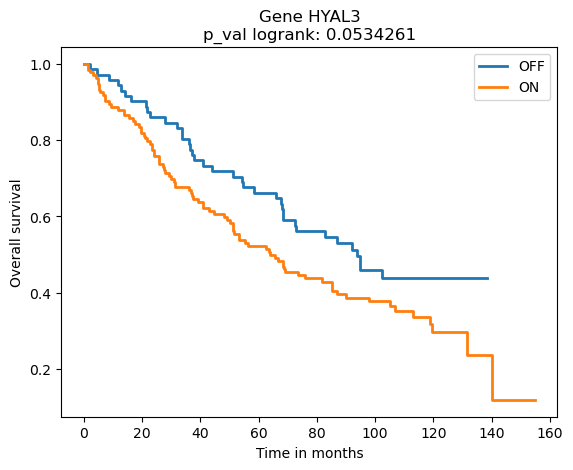

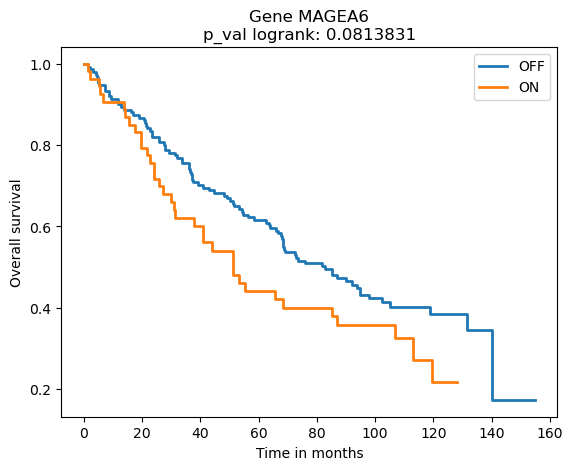

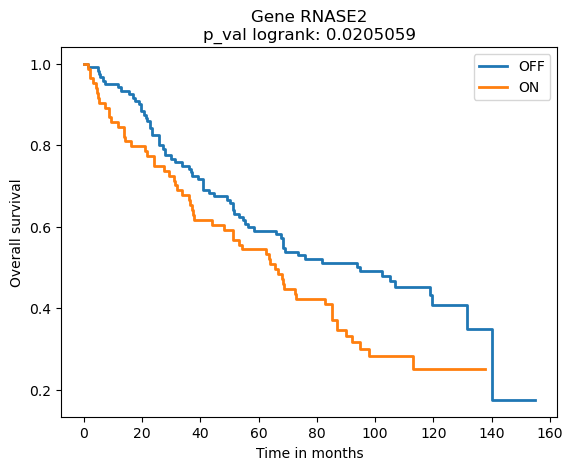

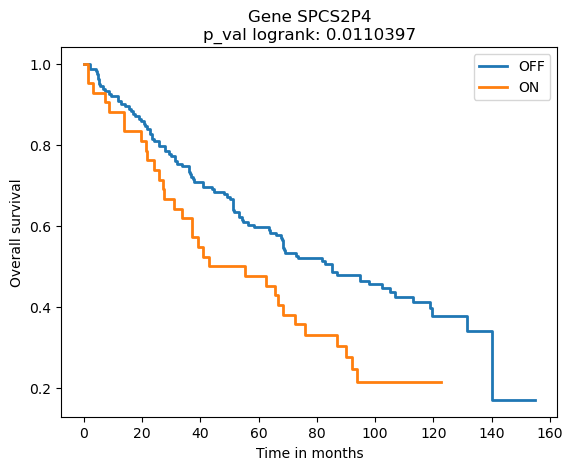

In [31]:
# Créer une instance de CoxPHFitter
coxph = CoxPHFitter()

# Boucle sur chaque ligne de seuil_ectopy
for i in range(len(seuil_ectopy)):
    
    # Récupération d'un gène
    gene_symbol = seuil_ectopy['Gene'].iloc[i]
    
    # ajout du gene dans data_cox_val
    data_cox_val.loc[i, 'gene_symbol'] = gene_symbol
    
    # Sélectionner les données d'expression du gène
    gene_data = expression_data_GSE141202[expression_data_GSE141202['gene_symbol'] == gene_symbol].drop(columns=['gene_symbol'])

    # Vérifiez si gene_data est vide
    if gene_data.empty:
        print(f"No data found for gene {gene_symbol}")
        continue

    # Créer un DataFrame à partir de gene_data
    df = pd.DataFrame(gene_data.values.T, columns=[gene_symbol])

    # Sélectionner uniquement la colonne du gène actuel pour le modèle de Cox
    X = pd.concat([data_surv.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
    X = X.dropna()  # Suppression des lignes de X contenant des NAN

    # Fit le modèle de Cox
    #val_cox = coxph.fit(X, duration_col='duration', event_col='event')
    # ajout de p_val_cox dans data_cox_val
    #data_cox_val.loc[i, 'pval_cox'] = round(val_cox.summary.loc[gene_symbol, 'p'], 7)

    # Binarisation données d'expression en utilisant le seuil calculé par ectopy
    seuil = seuil_ectopy['threshold_percentile'].iloc[i] / 100
    expression_bin = (gene_data.values.flatten() > np.quantile(gene_data.values.flatten(), seuil)).astype(int)
    
    # Vérifier qu'il y a bien deux groupes
    if len(np.unique(expression_bin)) != 1:
        
        # Log-rank test
        kmf = KaplanMeierFitter()
        kmf.fit(time, event_observed=event, label='Gene Expression')
        
        groups = pd.Series(expression_bin)
        ix = (groups == 0)
        
        kmf_low = KaplanMeierFitter()
        kmf_high = KaplanMeierFitter()
        
        
        kmf_low.fit(time[ix], event_observed=event[ix], label='OFF')
        kmf_high.fit(time[~ix], event_observed=event[~ix], label='ON')
        
        log_rank_result = statistics.logrank_test(time[ix], time[~ix], event_observed_A=event[ix], event_observed_B=event[~ix])
        
        #logrank_result = multivariate_logrank_test(temps, groups, censure)
        #logrank_p_value = logrank_results.p_value
        
        # ajout de la valeur de pval_logrank dans data_cox_val
        data_cox_val.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        ax = kmf_low.plot_survival_function(ci_show=False,linewidth=2)
        kmf_high.plot_survival_function(ax=ax, ci_show=False,linewidth=2)
        
        ## Ajout de la légende et du titre
        ax.set_title(f'Gene {gene_symbol}\np_val logrank: {data_cox_val.loc[i, "pval_logrank"]}')
        ax.set_xlabel('Time in months')
        ax.set_ylabel('Overall survival')
        
        plt.show()
        
        #log_rank_result = statistics.logrank_test(temps[ix], temps[~ix], event_observed_A=censure[ix], event_observed_B=censure[~ix])
        
        # ajout de la valeur de pval_logrank dans data_cox_val
        #data_cox_val.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        # Ajuster un modèle de Cox binaire pour le hazard ratio
        coxph.fit(pd.concat([shifted_time, shifted_event, pd.Series(expression_bin, name='expression_bin')], axis=1), duration_col='os_months', event_col='os_censor')
        
        # ajout du hazard_ratio dans data_cox_val
        data_cox_val.loc[i, 'hazard_ratio'] = coxph.hazard_ratios_['expression_bin']


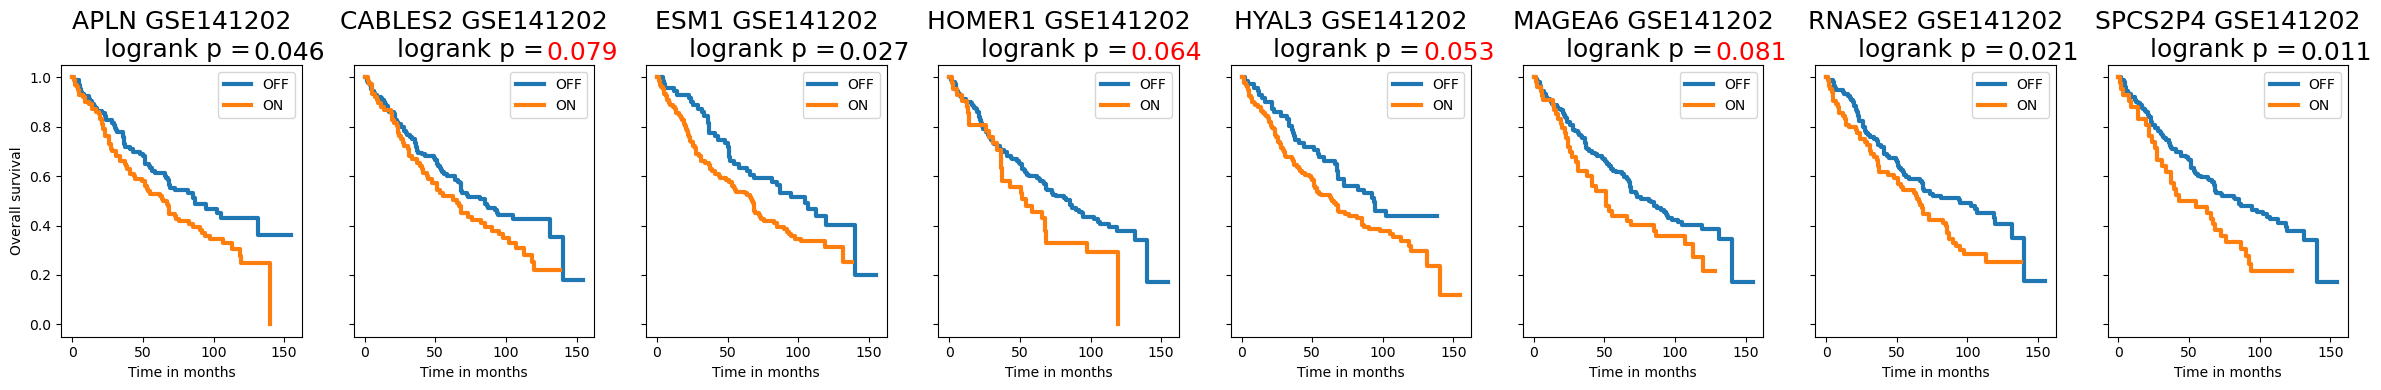

In [38]:
# Create a CoxPHFitter instance
coxph = CoxPHFitter()

# Prepare the data_cox DataFrame
data_cox = pd.DataFrame(columns=['gene_symbol', 'pval_logrank', 'hazard_ratio'])

# Set up the plotting figure
fig, axes = plt.subplots(1, 8, figsize=(24, 4), sharey=True)

#seuil_ectopy = seuil_ectopy[seuil_ectopy['Gene'].isin(['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6'])]

# Loop over each gene
for i in range(len(seuil_ectopy)):
    # Get the gene symbol
    gene_symbol = seuil_ectopy['Gene'].iloc[i]
    
    # Select the gene expression data
    gene_data = expression_data_GSE141202[expression_data_GSE141202['gene_symbol'] == gene_symbol].drop(columns=['gene_symbol'])
    
    # Check if gene_data is empty
    if gene_data.empty:
        print(f"No data found for gene {gene_symbol}")
        continue

    # Create a DataFrame from gene_data
    df = pd.DataFrame(gene_data.values.T, columns=[gene_symbol])

    # Combine the base data with gene expression data
    X = pd.concat([base.reset_index(drop=True), df.reset_index(drop=True)], axis=1).dropna()

    # Binarize the gene expression data
    seuil = seuil_ectopy['threshold_percentile'].iloc[i] / 100
    expression_bin = (gene_data.values.flatten() > np.quantile(gene_data.values.flatten(), seuil)).astype(int)
    
    # Check for two groups
    if len(np.unique(expression_bin)) != 1:
        # Log-rank test
        groups = pd.Series(expression_bin)
        ix = (groups == 0)
        
        kmf_low = KaplanMeierFitter()
        kmf_high = KaplanMeierFitter()
        
        kmf_low.fit(time[ix], event_observed=event[ix], label='OFF')
        kmf_high.fit(time[~ix], event_observed=event[~ix], label='ON')
        
        log_rank_result = logrank_test(time[ix], time[~ix], event_observed_A=event[ix], event_observed_B=event[~ix])
        
        # Add logrank p-value to data_cox
        data_cox.loc[i, 'gene_symbol'] = gene_symbol
        data_cox.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
         # Determine title color based on p-value
        pval_color = 'red' if data_cox.loc[i, 'pval_logrank'] > 0.05 else 'black'
        
        # Plot survival curves
        ax = axes[i]
        kmf_low.plot_survival_function(ax=ax, ci_show=False, linewidth=3)
        kmf_high.plot_survival_function(ax=ax, ci_show=False, linewidth=3)
        
         # Construct the title
        title_main = f'{gene_symbol} {clinic_data_GSE141202["main_gse_number"][0]}\nlogrank p = '
        title_pval = str(round(data_cox.loc[i, 'pval_logrank'],3))
        
        # Set the main part of the title
        ax.set_title(title_main, fontsize=18)
        
        # Add the colored p-value as text
        ax.text(0.8, 1.02, title_pval, color=pval_color, transform=ax.transAxes, ha='left', fontsize=18)
        
        ax.set_xlabel('Time in months')
        
        # Add legend and title
        #ax.set_title(f'{gene_symbol} {clinic_data_GSE141202["main_gse_number"][0]}\nlogrank p = {data_cox.loc[i, "pval_logrank"]}')
       # ax.set_xlabel('Time in months')
        if i == 0:
            ax.set_ylabel('Overall survival')
        
        # Fit Cox model to get hazard ratio
        coxph.fit(pd.concat([time, event, pd.Series(expression_bin, name='expression_bin')], axis=1), duration_col='os_months', event_col='os_censor')
        data_cox.loc[i, 'hazard_ratio'] = coxph.hazard_ratios_['expression_bin']

plt.tight_layout()
plt.show()

In [33]:
data_cox_val.head()

gene_symbol pval_logrank hazard_ratio
0        APLN     0.045767     1.427776
1     CABLES2     0.079148     1.372427
2        ESM1     0.026704     1.533843
3      HOMER1     0.064465     1.480469
4       HYAL3     0.053426     1.453495

In [36]:
data_cox_val = data_cox_val[data_cox_val['hazard_ratio'] > 1.]

In [37]:
data_cox_val.shape

(43, 3)

In [38]:
tab1 = data_cox_val[["gene_symbol","pval_logrank"]]

In [39]:
tab1.head()

gene_symbol pval_logrank
0        APLN     0.045767
1       ASIC1      0.10419
3    B4GALNT1     0.661299
4     C5orf58     0.141624
5     CABLES2     0.079148

In [40]:
resultat = pd.merge(tab, tab1, on='gene_symbol', how='inner')

In [41]:
resultat.head()

gene_symbol pval_logrank_x pval_logrank_y
0        APLN       0.002835       0.045767
1       ASIC1       0.022792        0.10419
2    B4GALNT1       0.001011       0.661299
3     C5orf58       0.000014       0.141624
4     CABLES2       0.042577       0.079148

In [42]:
data = resultat['pval_logrank_y'].sort_values().reset_index()
resultat = resultat.loc[data['index']]

In [43]:
resultat.head()

gene_symbol pval_logrank_x pval_logrank_y
36     SPCS2P4        0.00003        0.01104
27      RNASE2       0.006009       0.020506
12        ESM1       0.033593       0.026704
0         APLN       0.002835       0.045767
17       HYAL3       0.018191       0.053426

In [44]:
# Seuil
seuil = 0.05
# Fonction pour compter le nombre de valeurs inférieures au seuil pour chaque ligne
def count_values_below_threshold(row):
    return sum(row < seuil)

# Créer une nouvelle colonne en appliquant la fonction à chaque ligne du DataFrame
resultat['N1'] = resultat[["pval_logrank_x", "pval_logrank_y"]].apply(count_values_below_threshold, axis=1)

In [45]:
# Seuil
seuil = 0.1

# Fonction pour compter le nombre de valeurs inférieures au seuil pour chaque ligne
def count_values_below_threshold(row):
    return sum(row < seuil)

# Créer une nouvelle colonne en appliquant la fonction à chaque ligne du DataFrame
resultat['N2'] = resultat[["pval_logrank_x", "pval_logrank_y"]].apply(count_values_below_threshold, axis=1)

In [46]:
resultat.head()

gene_symbol pval_logrank_x pval_logrank_y  N1  N2
36     SPCS2P4        0.00003        0.01104   2   2
27      RNASE2       0.006009       0.020506   2   2
12        ESM1       0.033593       0.026704   2   2
0         APLN       0.002835       0.045767   2   2
17       HYAL3       0.018191       0.053426   1   2

In [47]:
# renaming
resultat.rename(columns={'pval_logrank_x': 'TCGA-LIHC'}, inplace=True)
resultat.rename(columns={'pval_logrank_y': 'GSE141202'}, inplace=True)

In [48]:
resultat.head()

gene_symbol TCGA-LIHC GSE141202  N1  N2
36     SPCS2P4   0.00003   0.01104   2   2
27      RNASE2  0.006009  0.020506   2   2
12        ESM1  0.033593  0.026704   2   2
0         APLN  0.002835  0.045767   2   2
17       HYAL3  0.018191  0.053426   1   2

In [49]:
resultat["TCGA-LIHC"] = resultat["TCGA-LIHC"].astype(float)
resultat["GSE141202"] = resultat["GSE141202"].astype(float)

In [50]:
# save DataFrame into CSV file

resultat.to_csv("train.csv", index=False, sep=";")

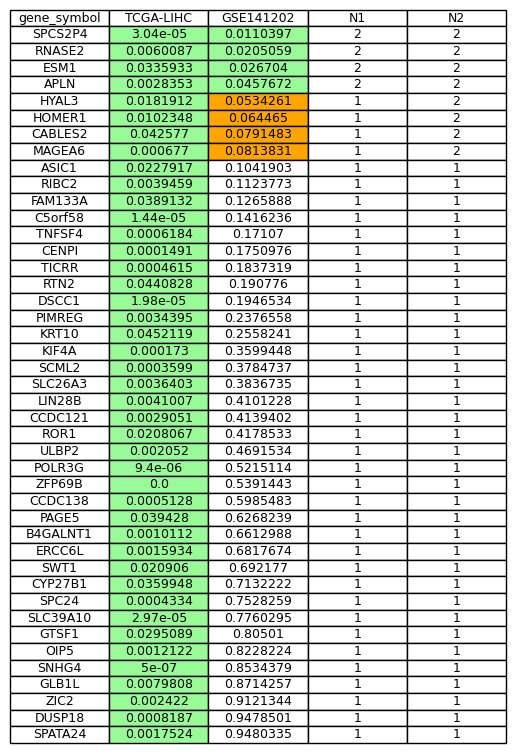

In [51]:
import matplotlib.pyplot as plt

# Créer une grille de couleurs avec la même taille que le DataFrame
colors = np.full(resultat.shape, fill_value='white', dtype='U25')

# Colorer les cellules 
for i in range(resultat.shape[0]):
    
    if resultat.iloc[i, 1] < 0.05:
            colors[i, 1] = 'palegreen'
    elif resultat.iloc[i, 1] < 0.1:
            colors[i, 1] = 'orange'


for i in range(resultat.shape[0]):
    
    if resultat.iloc[i, 2] < 0.05:
            colors[i, 2] = 'palegreen'
    elif resultat.iloc[i, 2] < 0.1:
            colors[i, 2] = 'orange'

#colors[3,2] = 'yellow'
# Créer la figure et l'axe
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')

# Créer le tableau avec les couleurs des cellules
table = ax.table(cellText=resultat.values, colLabels=resultat.columns, cellLoc='center', loc='center', cellColours=colors)

plt.show()

**Note:** Nous pouvons retenir les gènes 'SPCS2P4', 'RIBC2', 'TICRR', 'C5orf58' comme potentiels biomarqueurs pronostiques et pour la création de l'outil GEC. 

## Test: with dataset GSE144269

In [25]:
# import data 

# les 109 gènes retenus dans l'étape de croisement entre les datasets pour les gènes fréquemment activés
specific_gene = pd.read_csv("gene_symbol.csv", sep=';', header = None) 

# expression data
expression_data_GSE144269 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE144269_log_rpkm_140_samples_31263_genes.csv", sep=";")

# on récupère les données dont les gènes sont présents dans 109 gènes 
expression_data_GSE144269 = expression_data_GSE144269[expression_data_GSE144269['gene_symbol'].isin(specific_gene[0].values)]

# clinic data
clinic_data_GSE144269 = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_GSE144269.xlsx", sheet_name="standard exp_group")

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [26]:
expression_data_GSE144269.head()

id_gene gene_symbol  GSM4284605  GSM4284606  GSM4284607  GSM4284608  \
34         41       ASIC1    0.052529    0.205276    0.687550    0.073392   
265       343        AQP8    0.415556    0.106311    0.535436    0.160211   
1210     1594     CYP27B1    0.397517    0.292593    0.601611    0.323246   
1356     1811     SLC26A3    0.122061    0.101398    0.219794    0.026642   
1373     1828        DSG1    3.470736    2.430738    0.375783    1.600485   

      GSM4284609  GSM4284610  GSM4284611  GSM4284612  ...  GSM4284735  \
34      0.191685    0.114149    2.802252    0.117828  ...    0.099307   
265     0.255581    0.282363    0.048908    0.030379  ...    0.000000   
1210    0.733872    0.299987    2.053804    0.184610  ...    1.099675   
1356    0.052288    0.141328    0.000000    0.014542  ...    0.048142   
1373    1.927824    1.909970    0.078131    2.323908  ...    0.364667   

      GSM4284736  GSM4284737  GSM4284738  GSM4284739  GSM4284740  GSM4284741  \
34      0.089783    0.433477    0.139740    0.114323    0.145425    1.007218   
265     0.000000    0.064506    0.120616    0.058308    0.064143    0.060307   
1210    0.228562    0.620840    0.246658    2.648330    0.849619    1.389677   
1356    0.126614    0.061484    0.087150    0.028053    0.030893    0.139617   
1373    2.693275    1.264344    2.328428    0.222075    2.129369    3.631173   

      GSM4284742  GSM4284743  GSM4284744  
34      0.071610    0.867304    0.178912  
265     0.000000    0.263687    0.069734  
1210    0.362566    0.459658    0.426704  
1356    0.000000    1.773427    0.130017  
1373    1.735969    1.259142    2.171029  

[5 rows x 142 columns]

In [27]:
clinic_data_GSE144269.head()

id_sample main_gse_number id_platform                    sample_title  \
0  GSM4284608       GSE144269    GPL24676   pat 11 non-tumor [HDV_11B_S6]   
1  GSM4284691       GSE144269    GPL24676        pat 4 tumor [HDV_4A_S23]   
2  GSM4284654       GSE144269    GPL24676  pat 32 non-tumor [HDV_32B_S31]   
3  GSM4284737       GSE144269    GPL24676      pat 70 tumor [HDV_70A_S53]   
4  GSM4284631       GSE144269    GPL24676      pat 22 tumor [HDV_22A_S31]   

  sample_source  sex  ethnic_group  age_min  age_max  id_tissue_stage  ...  \
0  liver tissue  NaN           NaN     64.0     64.0                1  ...   
1  liver tissue  NaN           NaN     63.0     63.0                1  ...   
2  liver tissue  NaN           NaN     67.0     67.0                1  ...   
3  liver tissue  NaN           NaN     75.0     75.0                1  ...   
4  liver tissue  NaN           NaN     62.0     62.0                1  ...   

  os_months  relapsed   dead treatment exposure tissue_group_level1  \
0       NaN       NaN    NaN       NaN      NaN               liver   
1     41.50       NaN  False       NaN      NaN               liver   
2       NaN       NaN    NaN       NaN      NaN               liver   
3     19.10       NaN  False       NaN      NaN               liver   
4     40.93       NaN  False       NaN      NaN               liver   

  tissue_group_level2 tissue_group_level3 os_censor dfs_censor  
0       hepato_bilary                soma       NaN        NaN  
1       hepato_bilary                soma       0.0        NaN  
2       hepato_bilary                soma       NaN        NaN  
3       hepato_bilary                soma       0.0        NaN  
4       hepato_bilary                soma       0.0        NaN  

[5 rows x 40 columns]

In [28]:
clinic_data_GSE144269 = clinic_data_GSE144269.dropna(subset=['os_months', 'os_censor'])

In [29]:
clinic_data_GSE144269.shape

(70, 40)

In [30]:
# Sélection des échantillons tumoraux
clinic_data_GSE144269 = clinic_data_GSE144269[clinic_data_GSE144269['tissue_status'] == "tumoral"]

In [31]:
# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_GSE144269['id_sample'].unique() if col in expression_data_GSE144269.columns]

# Sélection des données
expression_data_GSE144269 = expression_data_GSE144269[['gene_symbol'] + selected_sample]

In [32]:
 #expression_data_GSE144269

In [33]:
expression_data_GSE144269.shape

(109, 71)

In [34]:
# Trouver les échantillons contenant des valeurs NaN dans expression_data_TCGA_LIHC
colonnes_avec_nan = expression_data_GSE144269.columns[expression_data_GSE144269.isna().any()].tolist()

print(colonnes_avec_nan)

[]


In [112]:
# Création du DataFrame data_cox_val( val : validation)
data_cox_test = pd.DataFrame(columns=['gene_symbol', 'pval_logrank', 'hazard_ratio'])

# données de survie
temps = clinic_data_GSE144269['os_months'].astype(float)
censure = clinic_data_GSE144269['os_censor'].astype(float)
survival_data = pd.DataFrame({'duration': temps, 'event': censure})

In [45]:
len(seuil_ectopy)

24

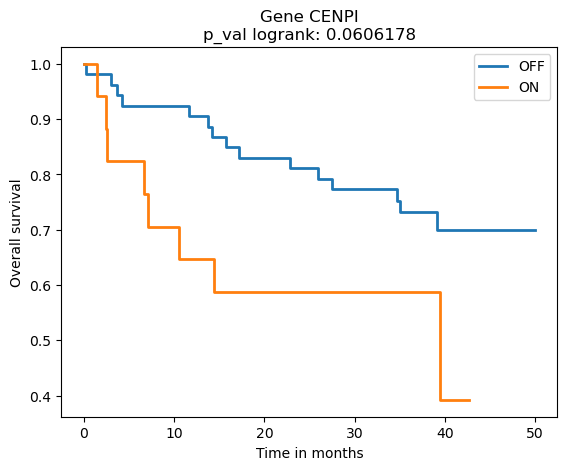

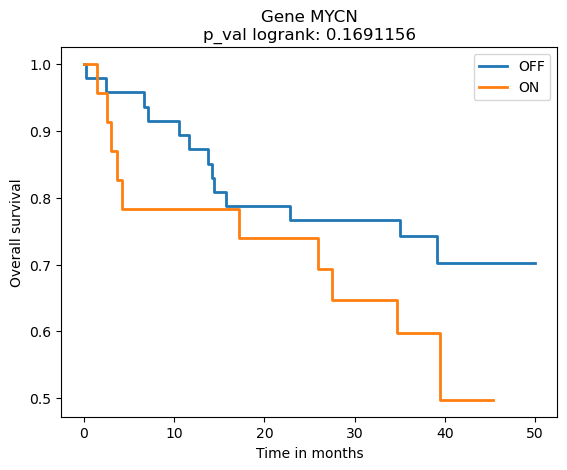

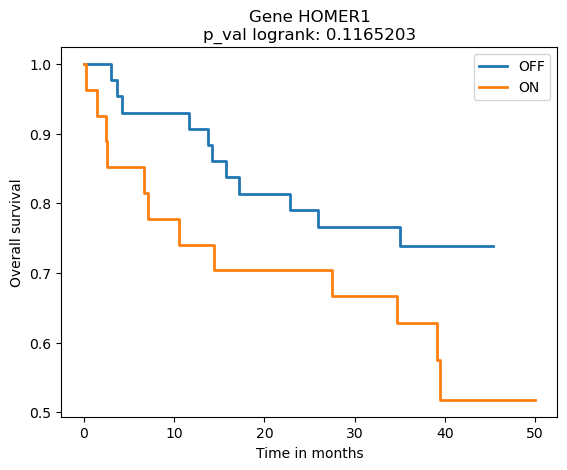

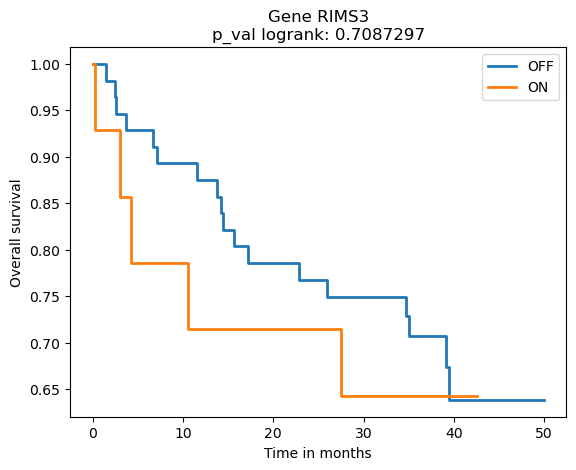

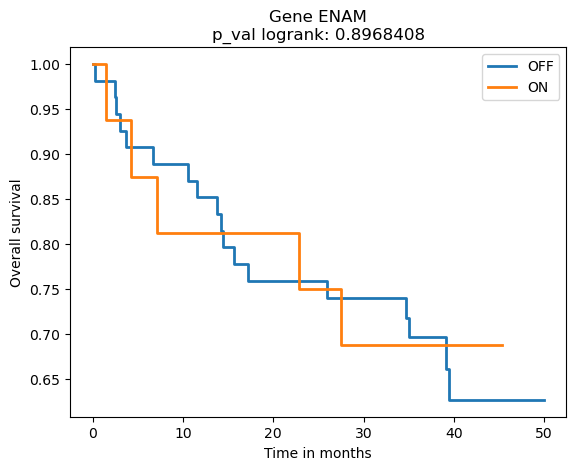

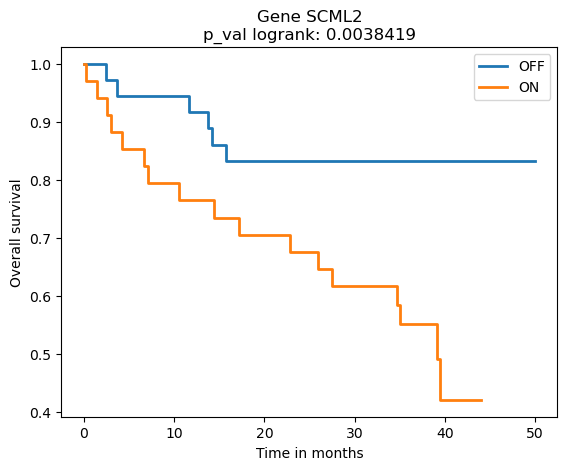

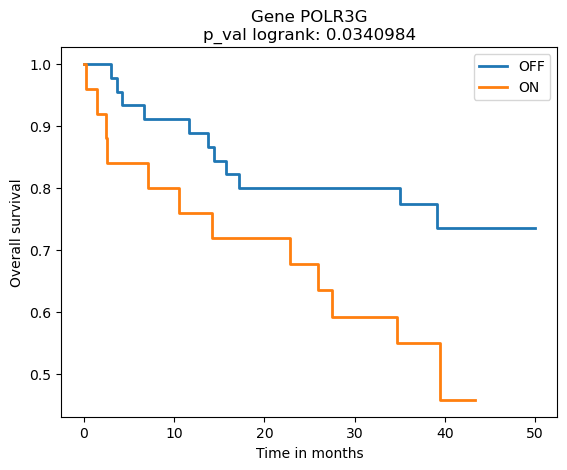

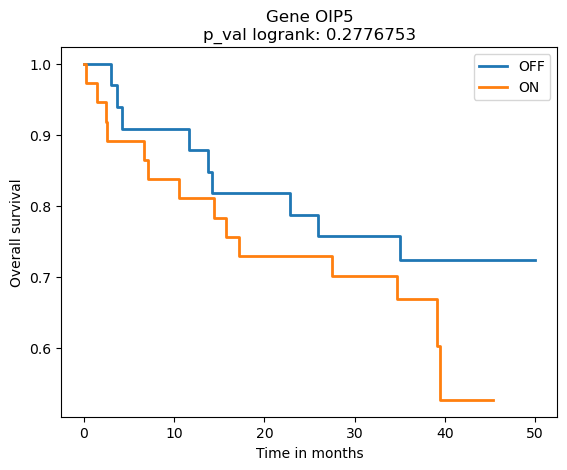

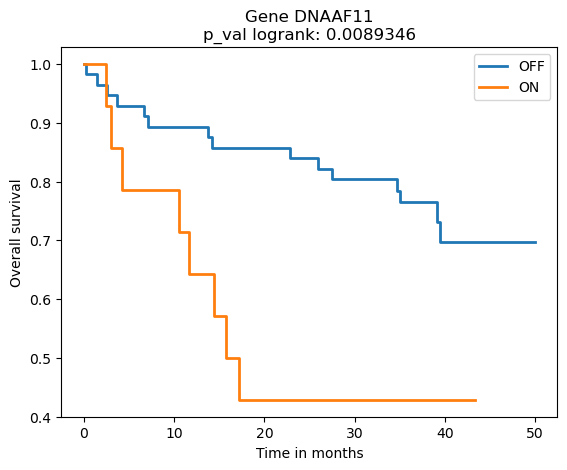

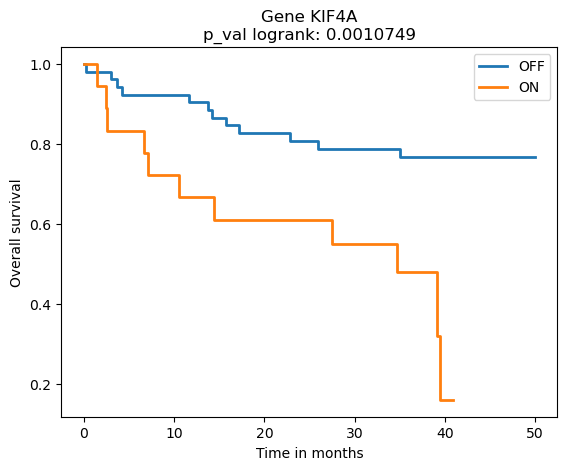

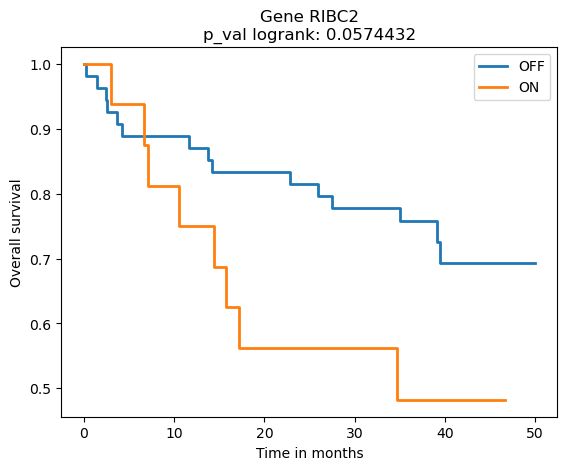

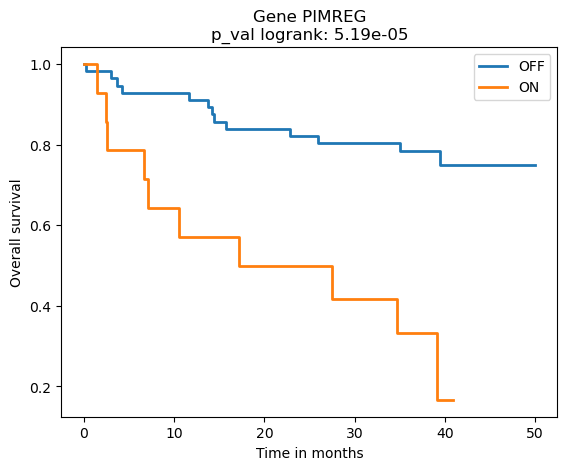

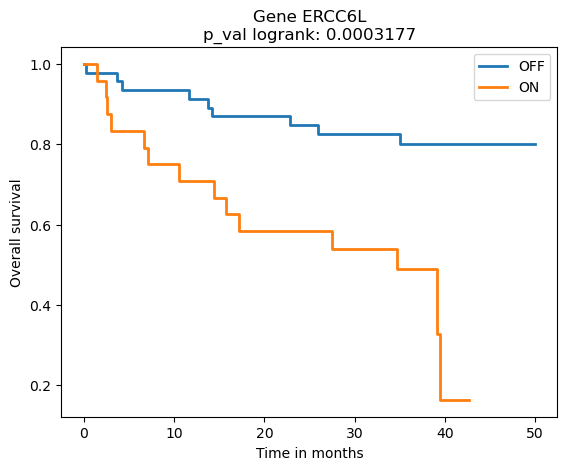

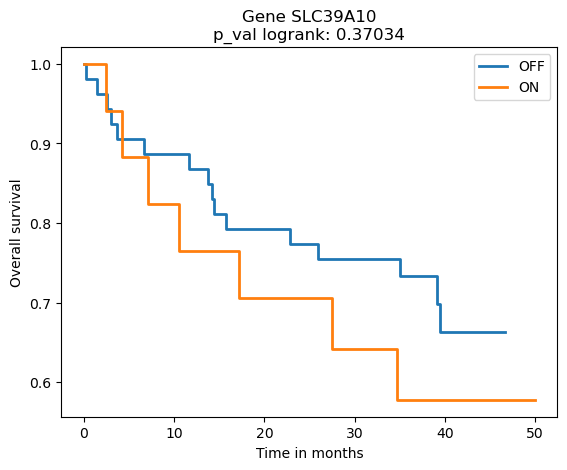

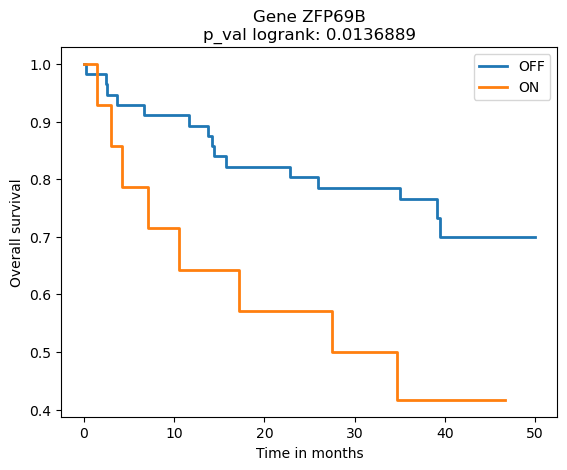

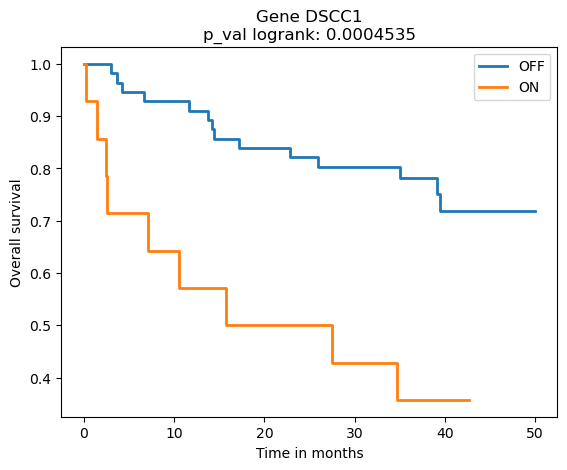

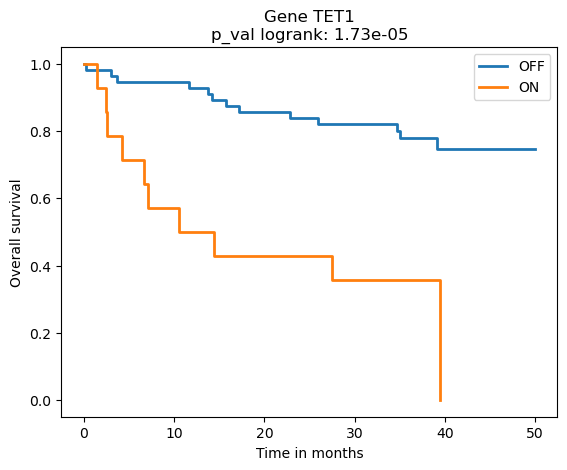

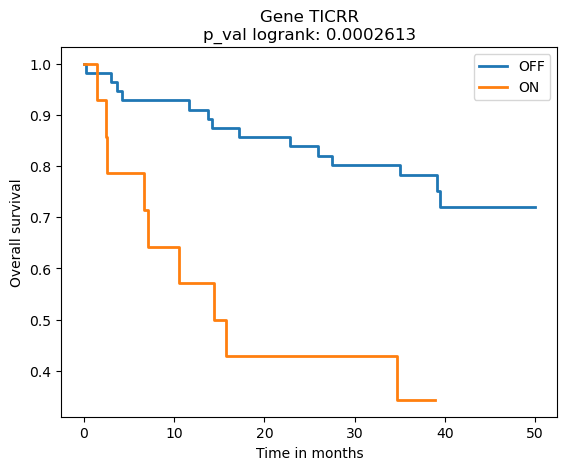

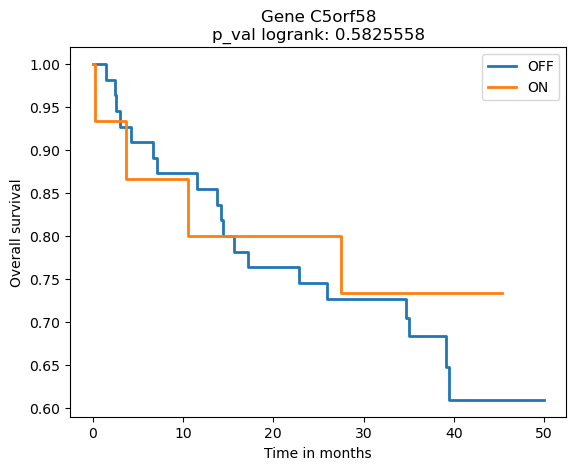

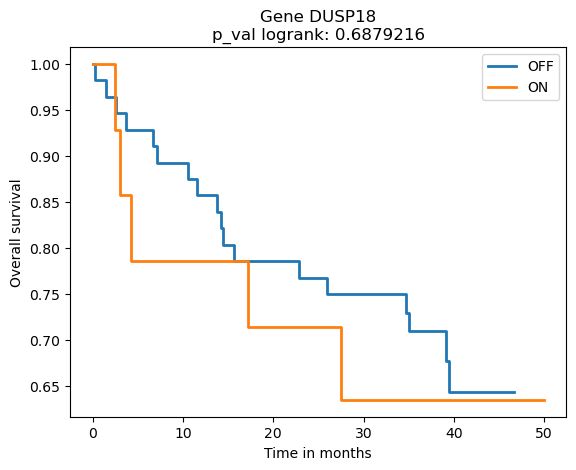

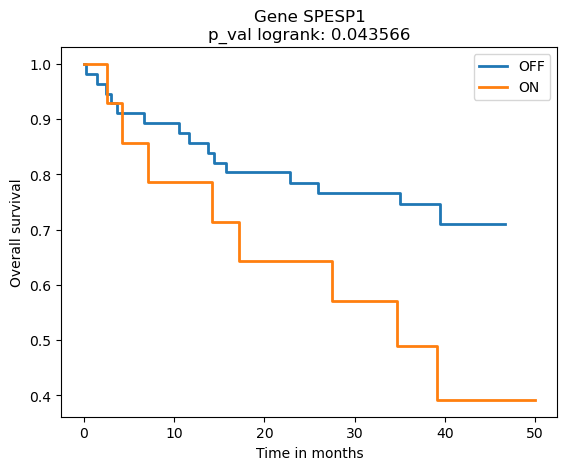

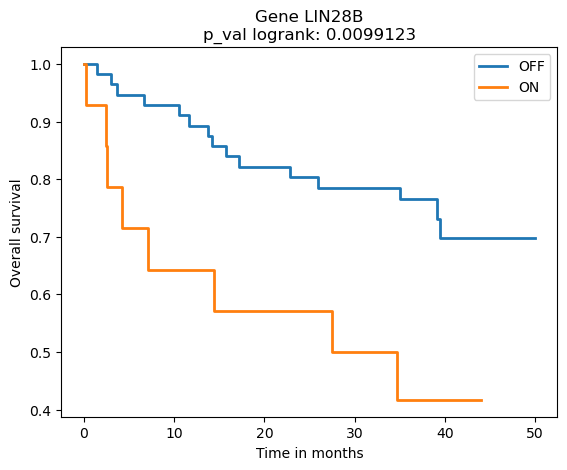

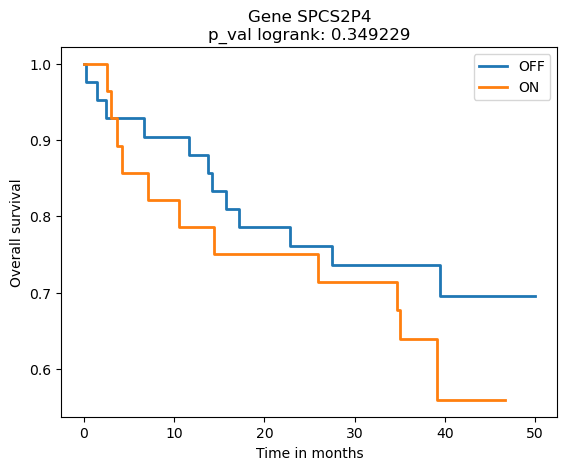

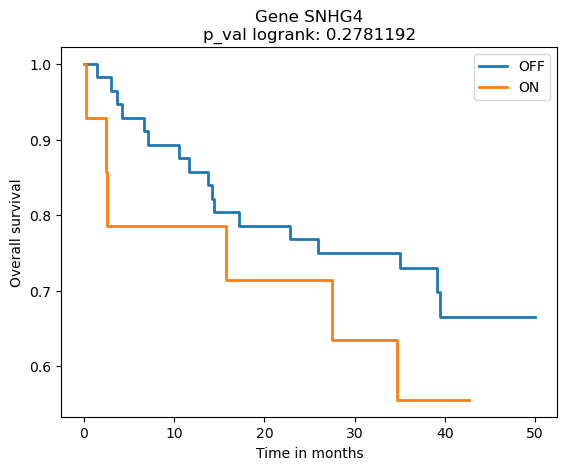

In [46]:
# Créer une instance de CoxPHFitter
coxph = CoxPHFitter()

# Boucle sur chaque ligne de seuil_ectopy
for i in range(len(seuil_ectopy)):
    
    # Récupération d'un gène
    gene_symbol = seuil_ectopy['gene_symbol'].iloc[i]
    
    # ajout du gene dans data_cox_val
    data_cox_test.loc[i, 'gene_symbol'] = gene_symbol
    
    # Sélectionner les données d'expression du gène
    gene_data = expression_data_GSE144269[expression_data_GSE144269['gene_symbol'] == gene_symbol].drop(columns=['gene_symbol'])

    # Vérifiez si gene_data est vide
    if gene_data.empty:
        print(f"No data found for gene {gene_symbol}")
        continue

    # Créer un DataFrame à partir de gene_data
    df = pd.DataFrame(gene_data.values.T, columns=[gene_symbol])

    # Sélectionner uniquement la colonne du gène actuel pour le modèle de Cox
    X = pd.concat([base.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
    X = X.dropna()  # Suppression des lignes de X contenant des NAN

    # Fit le modèle de Cox
    #val_cox = coxph.fit(X, duration_col='duration', event_col='event')
    # ajout de p_val_cox dans data_cox_val
    #data_cox_val.loc[i, 'pval_cox'] = round(val_cox.summary.loc[gene_symbol, 'p'], 7)

    # Binarisation données d'expression en utilisant le seuil calculé par ectopy
    seuil = seuil_ectopy['seuil_percentile'].iloc[i] / 100
    expression_bin = (gene_data.values.flatten() > np.quantile(gene_data.values.flatten(), seuil)).astype(int)
    
    # Vérifier qu'il y a bien deux groupes
    if len(np.unique(expression_bin)) != 1:
        
        # Log-rank test
        kmf = KaplanMeierFitter()
        kmf.fit(temps, event_observed=censure, label='Gene Expression')
        
        groups = pd.Series(expression_bin)
        ix = (groups == 0)
        
        kmf_low = KaplanMeierFitter()
        kmf_high = KaplanMeierFitter()
        
        
        kmf_low.fit(temps.reset_index(drop=True).loc[ix], event_observed=censure.reset_index(drop=True).loc[ix], label='OFF')
        kmf_high.fit(temps.reset_index(drop=True).loc[~ix], event_observed=censure.reset_index(drop=True).loc[~ix], label='ON')
        
        log_rank_result = statistics.logrank_test(temps.reset_index(drop=True).loc[ix], temps.reset_index(drop=True).loc[~ix], event_observed_A=censure.reset_index(drop=True).loc[ix], event_observed_B=censure.reset_index(drop=True).loc[~ix])
        
        # ajout de la valeur de pval_logrank dans data_cox_val
        data_cox_val.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        ax = kmf_low.plot_survival_function(ci_show=False,linewidth=2)
        kmf_high.plot_survival_function(ax=ax, ci_show=False,linewidth=2)
        
        ## Ajout de la légende et du titre
        ax.set_title(f'Gene {gene_symbol}\np_val logrank: {data_cox_val.loc[i, "pval_logrank"]}')
        ax.set_xlabel('Time in months')
        ax.set_ylabel('Overall survival')
        
        plt.show()
        
        #log_rank_result = statistics.logrank_test(temps[ix], temps[~ix], event_observed_A=censure[ix], event_observed_B=censure[~ix])
        
        # ajout de la valeur de pval_logrank dans data_cox_val
        #data_cox_val.loc[i, 'pval_logrank'] = round(log_rank_result.p_value, 7)
        
        # Ajuster un modèle de Cox binaire pour le hazard ratio
        coxph.fit(pd.concat([temps.reset_index(drop=True), censure.reset_index(drop=True), pd.Series(expression_bin, name='expression_bin')], axis=1), duration_col='os_months', event_col='os_censor')
        
        # ajout du hazard_ratio dans data_cox_val
        data_cox_val.loc[i, 'hazard_ratio'] = coxph.hazard_ratios_['expression_bin']


**Note :**

Les huit gènes 'SPCS2P4', 'RNASE2', 'ESM1', 'APLN', 'HYAL3', 'HOMER1', 'CABLES2' et 'MAGEA6' sont retenues pour créer un outil pronostic nommé GEC. Le GEC permet de stratifier les patients selon le nombre de gènes activés parmi les huit. 

## Analyse de corrélation des huit gènes du GEC :

Il est intéressant de réaliser une analyse de corrélation afin de s'assurer s'il est pertinent ou pas de garder les huit gènes du GEC.

In [14]:
# fonction pour automatiser le processus d'analyse de corrélation pour tous les datasets

def gene_corr(expression_data, dataset_name, gec):
    
    """
    expression_data : données d'expression de gènes
    dataset_name : nom du dataset, utile pour le titre du graphe
    gec : les 8 gènes constituant le gec
    
    """
    
    # pour faciliter la récupération des données d'expression, gene_symbol en indice
    exp_data = expression_data.set_index('gene_symbol') 
    
    ###########################################
    for i, gene_x in enumerate(gec):
        
        for j, gene_y in enumerate(gec):
            
            if i > j:   
                
                # expression data
                x = exp_data.loc[gene_x]
                y = exp_data.loc[gene_y]
                
                # Calcul du coefficient de corrélation
                c_pearson, p_pearson = pearsonr(x, y)
                
                # Création de la figure et des axes pour chaque paire de gènes
                fig, ax = plt.subplots()
                sns.regplot(x=x, y=y, ax=ax, scatter_kws={'s': 50}, line_kws={'color': 'black'}, ci=None)
                
                # Ajouter les noms des gènes aux axes
                ax.set_xlabel(gene_x)
                ax.set_ylabel(gene_y)
                
                # Titre et annotations
                ax.set_title(f"{dataset_name} (n={len(x)})\nPearson correlation coefficient = {c_pearson:.2f}\np-value = {p_pearson:.1e}")
                
                # Afficher le graphe
                plt.show()

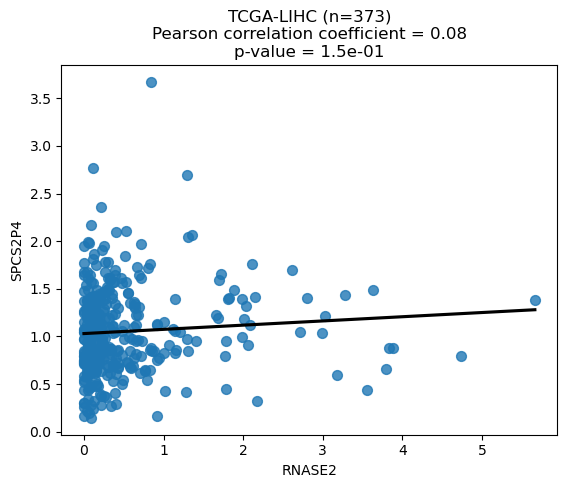

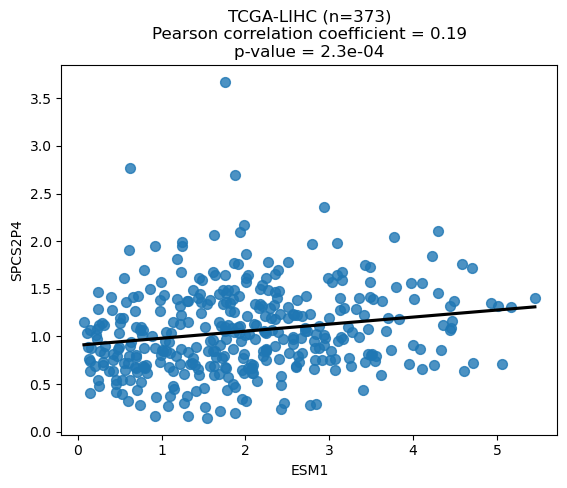

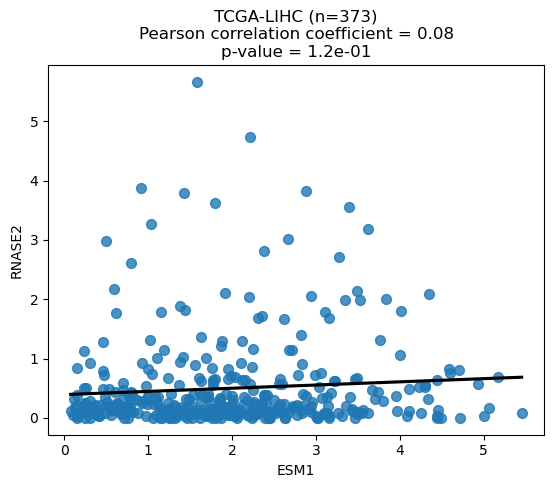

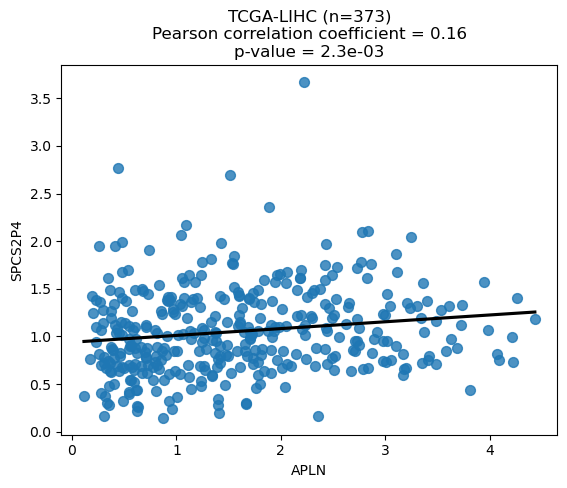

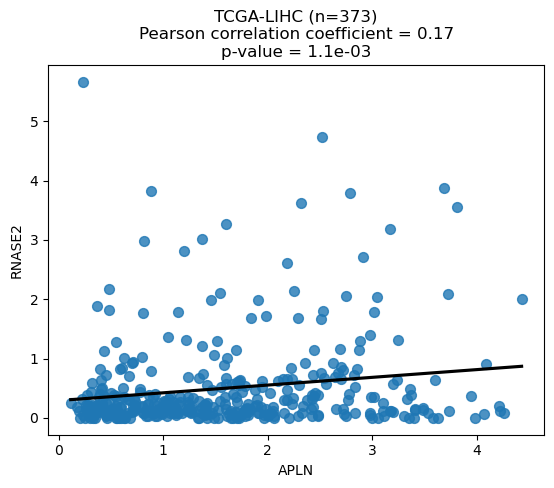

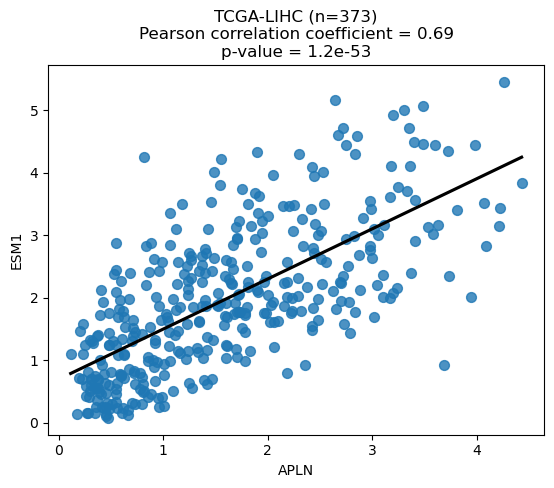

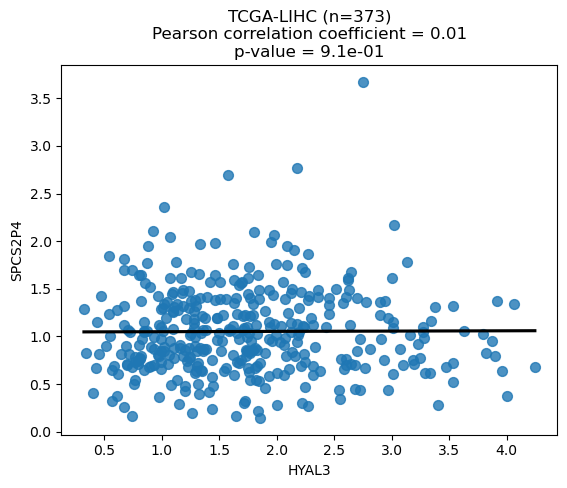

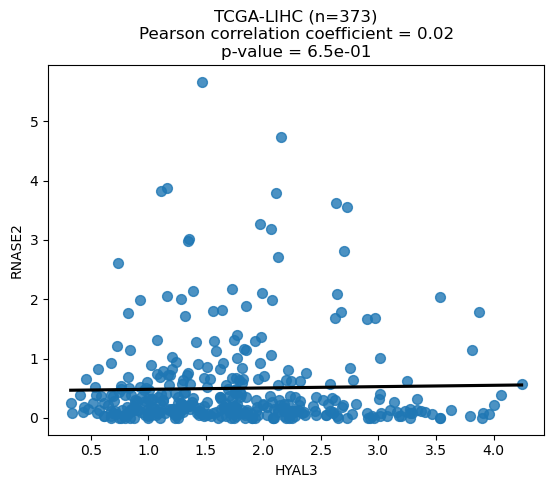

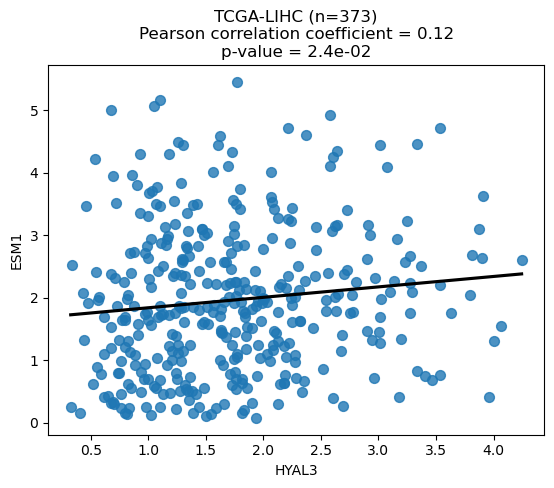

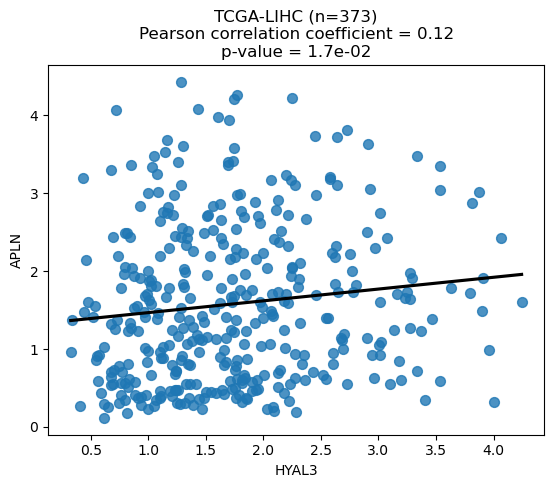

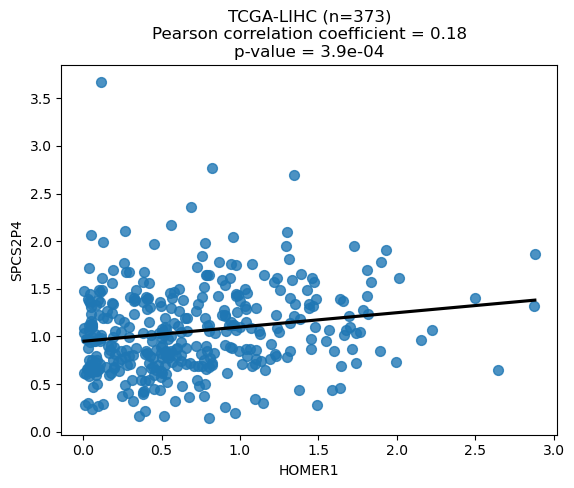

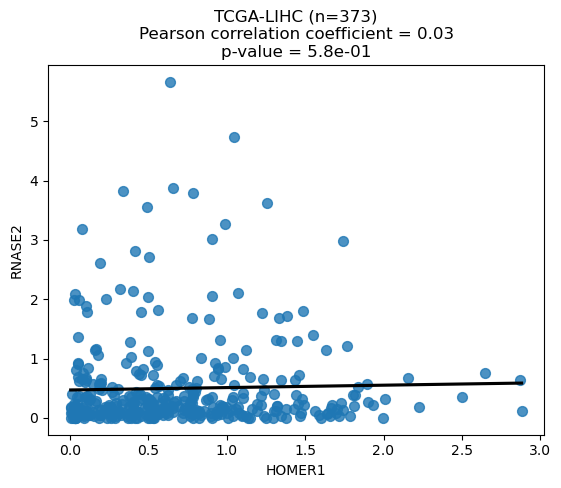

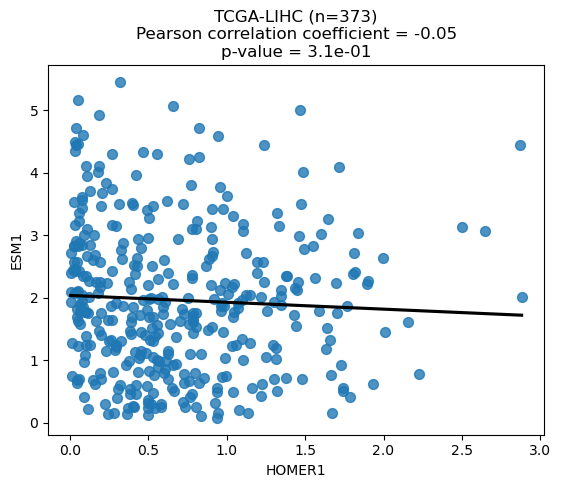

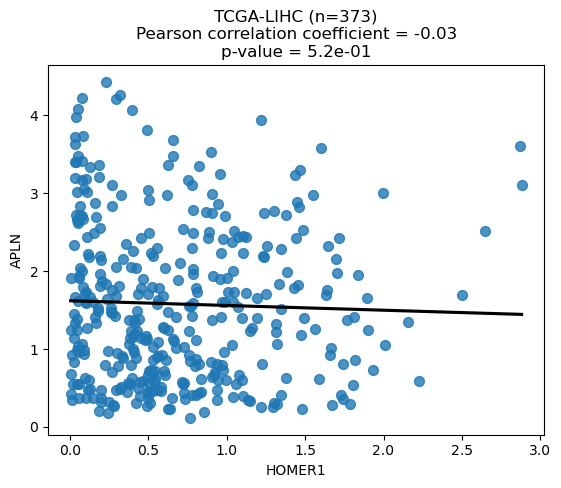

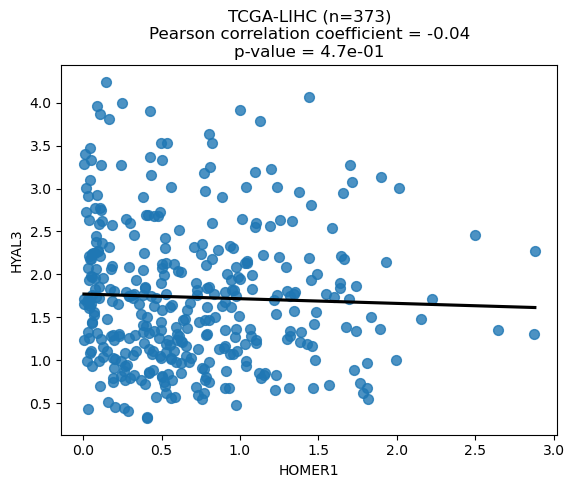

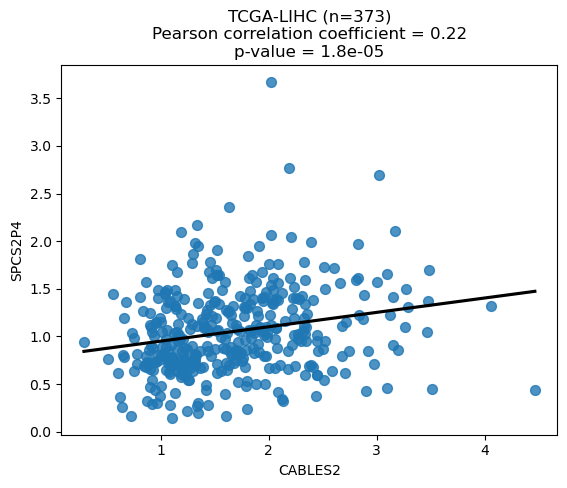

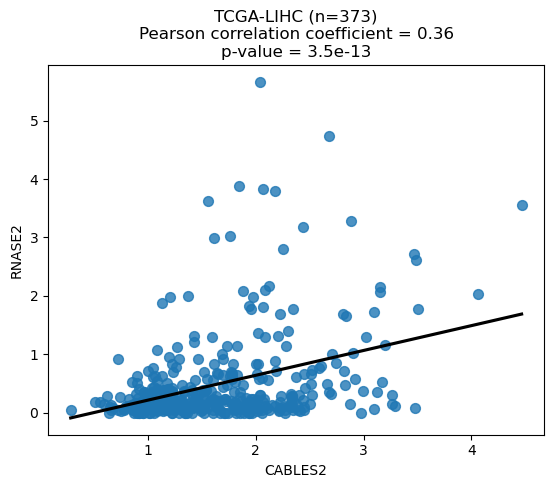

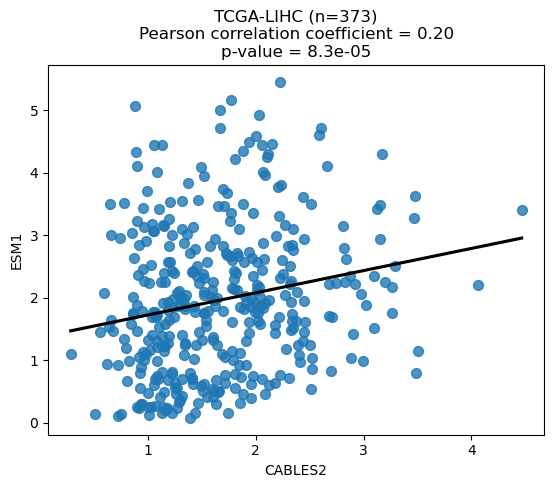

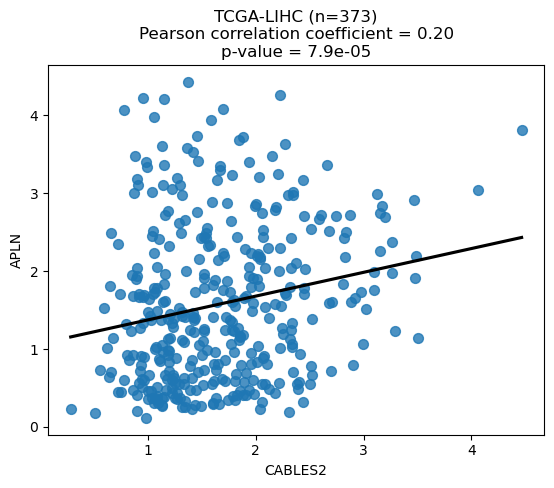

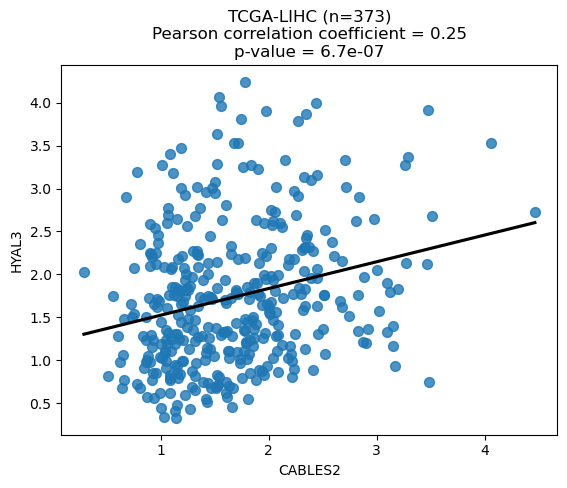

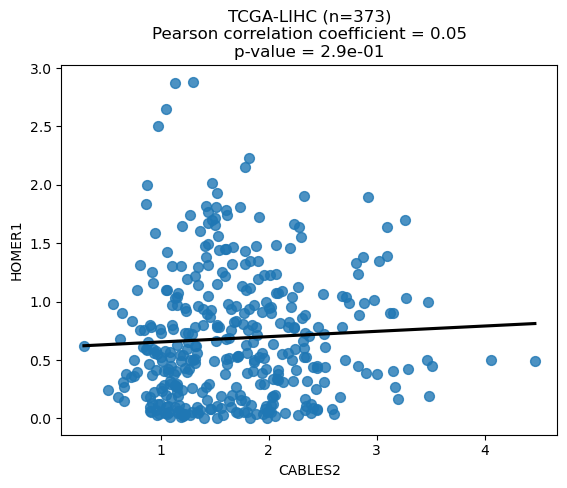

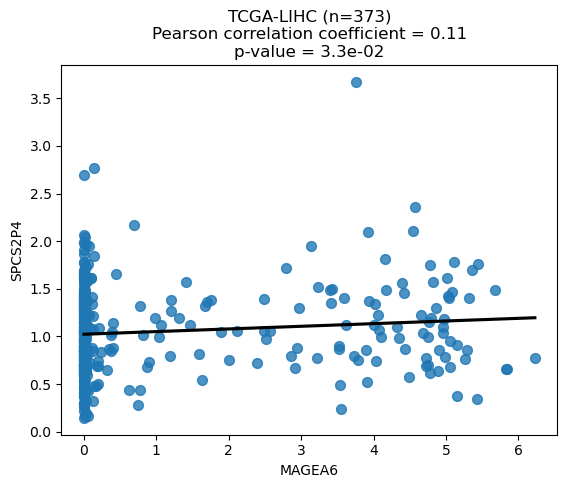

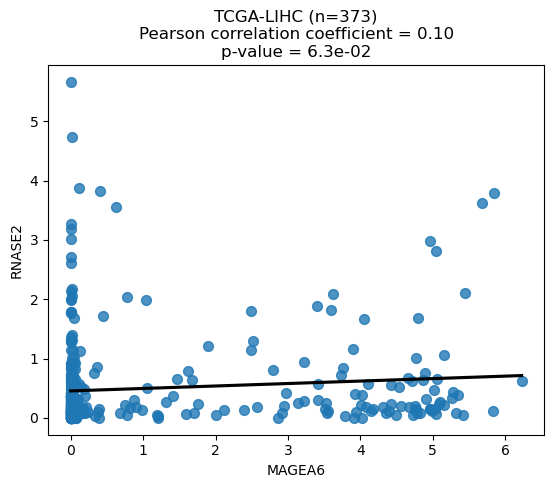

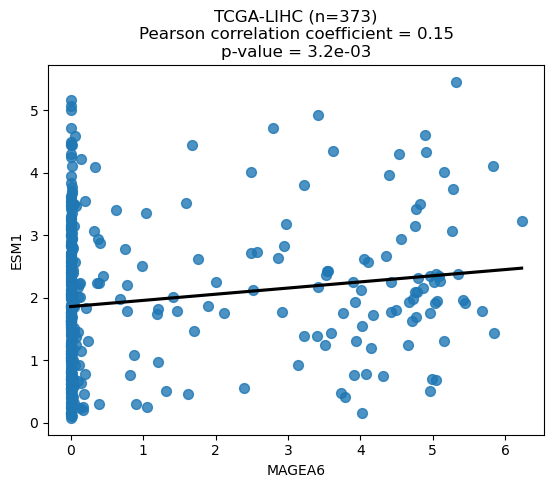

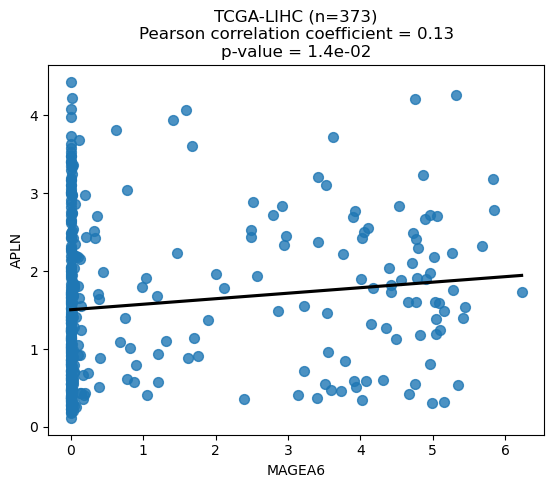

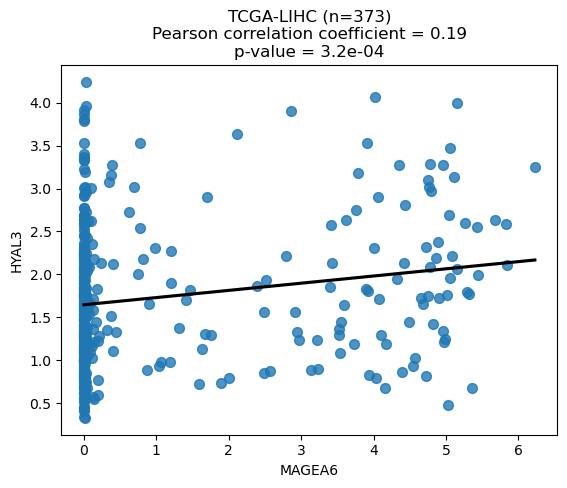

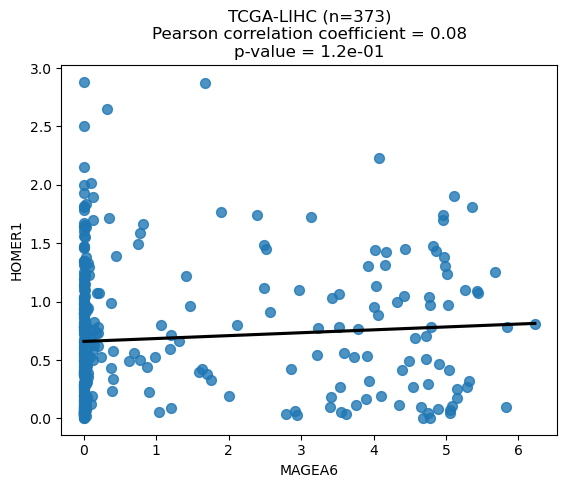

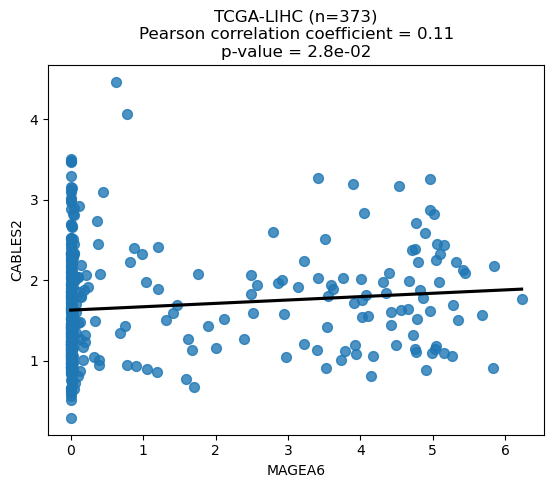

In [16]:
# exemple d'utilisation de la focntion gene_corr

# avec le dataset TCGA-LIHC

# genes retenus comme candidats pour le gec
biomarqueur = ['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6']

gene_corr(expression_data_TCGA_LIHC, "TCGA-LIHC", biomarqueur) 

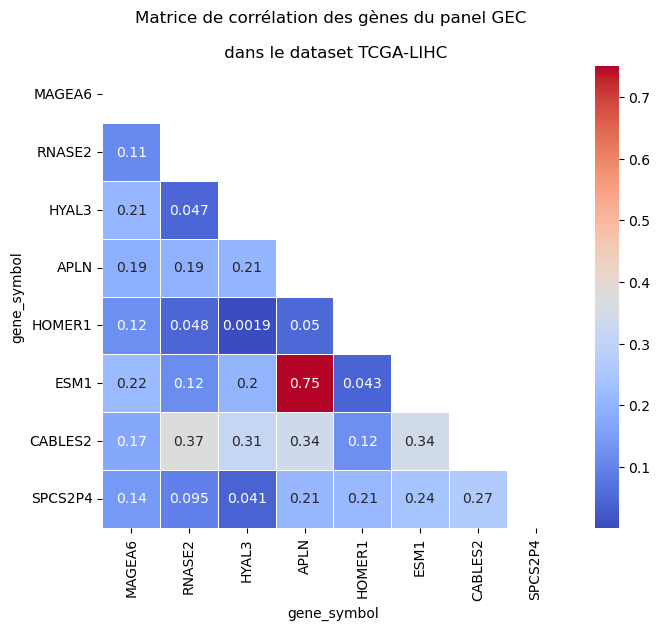

In [84]:
# expression data
expression_data_TCGA_LIHC = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_tcga_lihc_TCGA-LIHC_log_fpkm_439_samples_43022_genes.csv", sep=";")

# suppression des échantillons qui ont des valeurs manquantes(NAN)
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.dropna(axis=1) 

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'].isin(['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6'])]

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.drop('id_gene', axis=1).set_index('gene_symbol')

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.T

# Calcul de la matrice de corrélation
M = expression_data_TCGA_LIHC.corr()


# Création d'un masque pour la matrice de corrélation
mask = np.triu(np.ones_like(M, dtype=bool))

# Définir la taille de la figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de corrélation avec le masque
sns.heatmap(M, mask=mask, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

# Titre de la carte thermique
plt.title("Matrice de corrélation des gènes du panel GEC \n \n dans le dataset TCGA-LIHC")

# Afficher la carte thermique
plt.show()


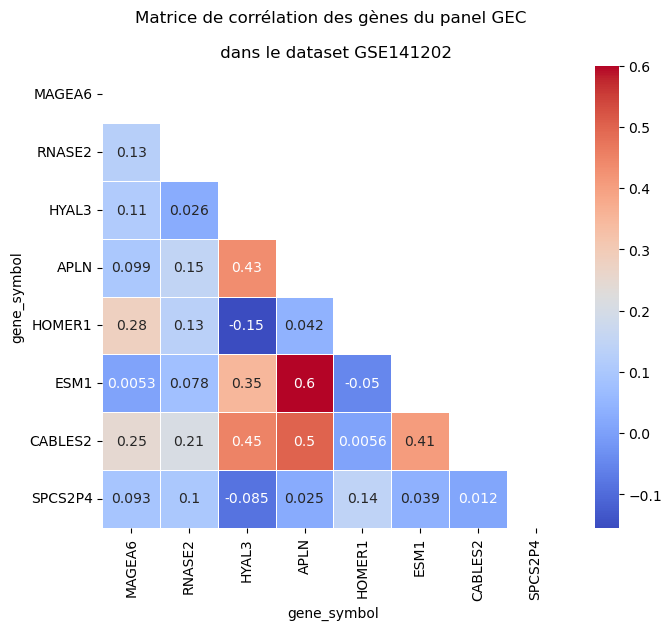

In [85]:
# expression data
expression_data_GSE141202 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE141202_log_rpkm_206_samples_38133_genes.csv", sep=";")

expression_data_GSE141202 = expression_data_GSE141202[expression_data_GSE141202['gene_symbol'].isin(['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6'])]

expression_data_GSE141202 = expression_data_GSE141202.drop('id_gene', axis=1).set_index('gene_symbol')

expression_data_GSE141202 = expression_data_GSE141202.T

# Calcul de la matrice de corrélation
M = expression_data_GSE141202.corr()


# Création d'un masque pour la matrice de corrélation
mask = np.triu(np.ones_like(M, dtype=bool))

# Définir la taille de la figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de corrélation avec le masque
sns.heatmap(M, mask=mask, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

# Titre de la carte thermique
plt.title("Matrice de corrélation des gènes du panel GEC \n \n dans le dataset GSE141202")

# Afficher la carte thermique
plt.show()


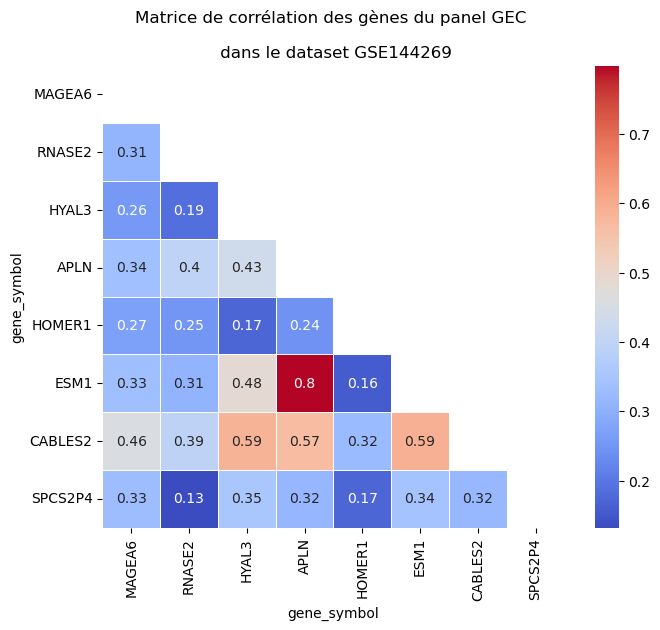

In [86]:
# expression data

expression_data_GSE144269 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE144269_log_rpkm_140_samples_31263_genes.csv", sep=";")

expression_data_GSE144269 = expression_data_GSE144269[expression_data_GSE144269['gene_symbol'].isin(['SPCS2P4','RNASE2','ESM1','APLN','HYAL3','HOMER1','CABLES2','MAGEA6'])]

expression_data_GSE144269 = expression_data_GSE144269.drop('id_gene', axis=1).set_index('gene_symbol')

expression_data_GSE144269 = expression_data_GSE144269.T

# Sélection des colonnes
selected_columns = expression_data_GSE144269

# Calcul de la matrice de corrélation
M = selected_columns.corr()


# Création d'un masque pour la matrice de corrélation
mask = np.triu(np.ones_like(M, dtype=bool))

# Définir la taille de la figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de corrélation avec le masque
sns.heatmap(M, mask=mask, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

# Titre de la carte thermique
plt.title("Matrice de corrélation des gènes du panel GEC \n \n dans le dataset GSE144269")

# Afficher la carte thermique
plt.show()


**Note :**

D'après les matrices de corrélation ci-dessus, nous pouvons dire que les gènes **APLN** et **ESM1** sont corrélés. Donc, il faut garder un seul gène parmi les deux pour éviter une redondance.  Nous avons décidé de garder le gène ESM1 car il présente des propriétés plus intéressantes. 

Pour la suite du projet, le GEC sera constitué de 7 gènes suite à l'exclusion du gène APLN.

## GEC: Gene Expression Classifier

L'outil GEC sera donc formé d'un panel de sept gènes ci-dessous.

In [82]:
# genes retenus comme candidats pour le gec
biomarqueur = ['SPCS2P4','RNASE2','ESM1','HYAL3','HOMER1','CABLES2','MAGEA6']
biomarqueur[0]

'SPCS2P4'

Ci-après, nous allons créer une fonction nommée "make_GEC" qui va nous permettre d'identifier pour chaque échantillon des trois datasets(train, validation et test), le nombre d'activation dans le panel des sept gènes. 

In [83]:
def make_GEC(data, gene_biomarqueur, seuil_ectopy):
    """
    data :  expression data
    gene_biomarqueur : panel GEC des huit gènes candidats
    seuil_ectopy : thresholds calculated by "ectopy"
    """
   
    tab_GEC = {
        'id_sample': [],
        'SPCS2P4': [],
        'RNASE2': [],
        'ESM1': [],
        'HYAL3': [],
        'HOMER1': [],
        'CABLES2': [],
        'MAGEA6': [],
        'Gec': []
    }

    for i in range(1, data.shape[1]):
        id_sample = data.columns[i]
        tab_GEC['id_sample'].append(id_sample)
        num_active_genes = 0

        for gene in gene_biomarqueur:
            seuil = seuil_ectopy.loc[seuil_ectopy['Gene'] == gene, 'threshold_percentile'].values[0] / 100
            quantile_value = np.quantile(data.loc[data['gene_symbol'] == gene].iloc[:, 1:], seuil)
            gene_value = data.loc[data['gene_symbol'] == gene].iloc[:, i].astype(float)
            x = (gene_value > quantile_value).astype(int).values[0]
            num_active_genes += x
            tab_GEC[gene].append(x)
        
        tab_GEC['Gec'].append(num_active_genes)
        
    tab_GEC_df = pd.DataFrame(tab_GEC)

    return tab_GEC_df


In [37]:
# appel de la fonction make_GEC dans le dataset TCGA_LIHC

data_gec_TCGA_LIHC = make_GEC(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
data_gec_TCGA_LIHC.head()

id_sample  SPCS2P4  RNASE2  ESM1  APLN  HYAL3  HOMER1  CABLES2  \
0  TCGA-G3-A3CG-01A        1       0     0     0      0       0        0   
1  TCGA-DD-AAVP-01A        0       1     1     1      1       0        1   
2  TCGA-FV-A3R3-01A        0       0     0     0      0       0        0   
3  TCGA-G3-A25Y-01A        1       1     0     0      1       0        1   
4  TCGA-DD-AADU-01A        0       0     1     1      1       0        0   

   MAGEA6  Gec  
0       0    1  
1       0    5  
2       0    0  
3       0    4  
4       0    3

In [38]:
# GSE141202

data_gec_GSE141202 = make_GEC(expression_data_GSE141202, biomarqueur, seuil_ectopy)
data_gec_GSE141202.head()

id_sample  SPCS2P4  RNASE2  ESM1  APLN  HYAL3  HOMER1  CABLES2  MAGEA6  \
0  GSM4196911        0       0     0     1      1       0        0       0   
1  GSM4196912        0       0     0     0      1       0        0       0   
2  GSM4196913        1       0     0     0      1       0        1       1   
3  GSM4196914        0       0     0     0      0       0        0       0   
4  GSM4196915        0       0     0     0      1       0        1       1   

   Gec  
0    2  
1    1  
2    4  
3    0  
4    3

In [39]:
# GSE144269

data_gec_GSE144269 = make_GEC(expression_data_GSE144269, biomarqueur, seuil_ectopy)
data_gec_GSE144269.head()

id_sample  SPCS2P4  RNASE2  ESM1  APLN  HYAL3  HOMER1  CABLES2  MAGEA6  \
0  GSM4284691        0       0     1     1      0       1        0       0   
1  GSM4284737        0       1     0     0      1       0        1       0   
2  GSM4284631        0       1     0     0      0       0        0       0   
3  GSM4284671        0       1     1     1      1       0        1       0   
4  GSM4284611        0       0     1     1      1       1        0       1   

   Gec  
0    3  
1    3  
2    1  
3    5  
4    5

In [40]:
### concaténation des trois dataframes résultants

data_gec_concat = pd.concat([data_gec_TCGA_LIHC, data_gec_GSE141202, data_gec_GSE144269])
data_gec_concat.head()

id_sample  SPCS2P4  RNASE2  ESM1  APLN  HYAL3  HOMER1  CABLES2  \
0  TCGA-G3-A3CG-01A        1       0     0     0      0       0        0   
1  TCGA-DD-AAVP-01A        0       1     1     1      1       0        1   
2  TCGA-FV-A3R3-01A        0       0     0     0      0       0        0   
3  TCGA-G3-A25Y-01A        1       1     0     0      1       0        1   
4  TCGA-DD-AADU-01A        0       0     1     1      1       0        0   

   MAGEA6  Gec  
0       0    1  
1       0    5  
2       0    0  
3       0    4  
4       0    3

### Courbes de survie

In [65]:
from lifelines.statistics import multivariate_logrank_test

def surv_plot(data, clinic_data, group_col,w,col):
    
    """
    data :       dataframe returned by make_gec function
    clinc_data : epimed experimental grouping data
    group_col : 'Gec'
    w :          train, validation, test
    col :        color
    
    """
     
    # S'assurez que les indices correspondent
    clinic_data = clinic_data.set_index('id_sample')  
    data = data.set_index('id_sample')
    
    # Données de survie
    temps = clinic_data['os_months'].astype(float)
    censure = clinic_data['os_censor'].astype(float)
    
    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Obtenir les valeurs uniques de Gec trie
    unique_groups = sorted(data[group_col].unique())
    
    # Répéter les mêmes étapes pour chaque groupe
    kmf = KaplanMeierFitter()
    
    # boucler sur chaque valeur de Gec
    for group in unique_groups:
        val = (data[group_col] == group)
        kmf.fit(temps[val], censure[val], label=f"{group_col}={group} (n={val.sum()})")
        kmf.plot(ax=ax, ci_show=False, linewidth=3)
    
    # Test de log-rank global
    logrank_results = multivariate_logrank_test(temps, data[group_col], censure)
    logrank_p_value = logrank_results.p_value
    
    # Ajustement du modèle de Cox
    cph = CoxPHFitter()
    data_surv = data[[group_col]].copy()
    data_surv['time'] = temps
    data_surv['event'] = censure
    cph.fit(data_surv, duration_col='time', event_col='event')
    
    # Résumé du modèle de Cox
    cox_summary = cph.summary
    cox_p_value = cox_summary.loc[group_col, 'p']
    #hazard_ratio = cox_summary.loc[group_col, 'exp(coef)']
    hazard_ratio = cph.hazard_ratios_[group_col]
    
    # Ajouter le titre et les labels des axes
    plt.title(f"{clinic_data['main_gse_number'][0]}\nLog-rank p-value: {logrank_p_value:.3e}\nCox p-value: {cox_p_value:.3e}\nHazard Ratio: {hazard_ratio:.2f}")
    plt.xlabel('Time in months')
    plt.ylabel('Overall survival')
    plt.xlim(0, 60)
    
    # Ajouter la légende
    plt.legend(title='GEC')
    
    # Afficher les résultats des tests sur le graphique
    textstr = w
    
    plt.gcf().text(0.35, 0.15, textstr, fontsize=10, bbox=dict(facecolor=col, alpha=0.5))

    # Afficher le graphique
    plt.show()

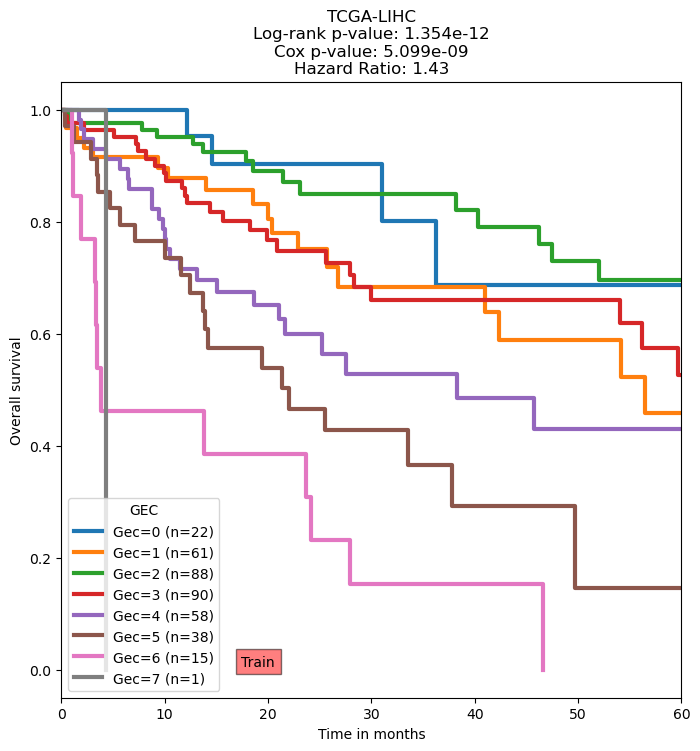

In [45]:
# train

data_gec = make_GEC(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
clinic_data_TCGA_LIHC.loc[:, "Gec"] = data_gec['Gec']

# Appel de la fonction surv_plot
surv_plot(data_gec, clinic_data_TCGA_LIHC, 'Gec','Train','red')


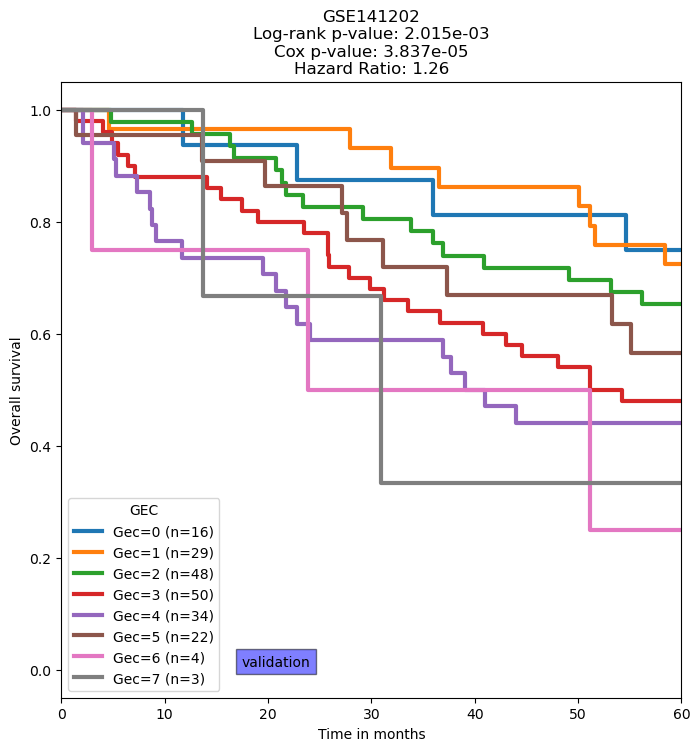

In [46]:
data_gec = make_GEC(expression_data_GSE141202, biomarqueur, seuil_ectopy)
clinic_data_GSE141202.loc[:, "Gec"] = data_gec['Gec']

# Appel de la fonction surv_plot
surv_plot(data_gec, clinic_data_GSE141202, 'Gec','validation','blue')


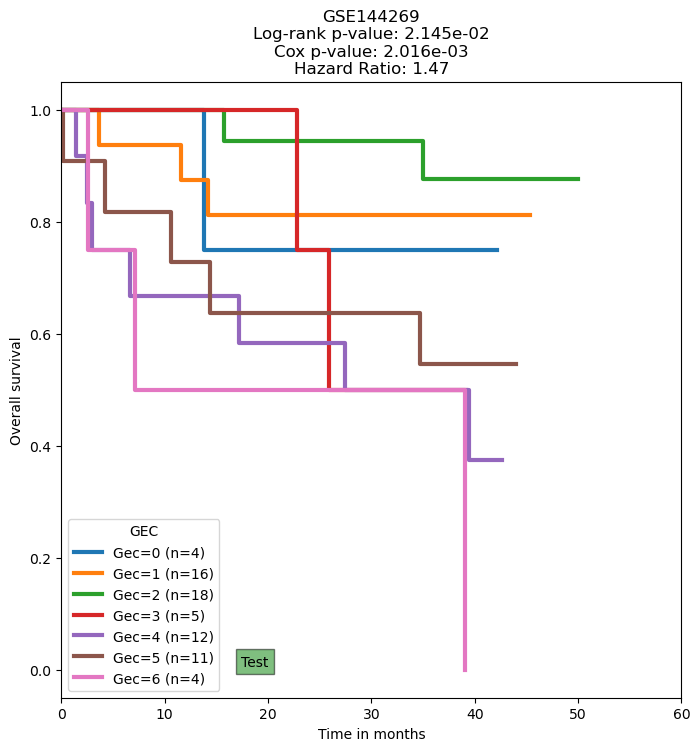

In [66]:
data_gec = make_GEC(expression_data_GSE144269, biomarqueur, seuil_ectopy)
clinic_data_GSE144269.loc[:, "Gec"] = data_gec['Gec']

# Appel de la fonction surv_plot
surv_plot(data_gec, clinic_data_GSE144269, 'Gec','Test','green')


Nous allons maintenant regrouper les valeurs de Gec en deux groupes: 0-2 d'une part et 3-7 d'autre part.

## Gec : 0-2 et 3-7

Nous modifions la fonction make_GEC pour adopter la nouvelle stratéfie.

In [48]:
def make_GEC_bis(data, gene_biomarqueur, seuil_ectopy):
    
    """
    data :       dataframe returned by make_gec function
    clinc_data : epimed experimental grouping data
    group_col : 'Gec'
    w :          train, validation, test
    col :        color
    
    """
    
    Gec = []
    
    for i in range(1, data.shape[1]):
        x = []
        
        for j in range(len(gene_biomarqueur)):
            
            gene_symbol = gene_biomarqueur[j]
            
            seuil = seuil_ectopy.loc[seuil_ectopy['Gene'] == gene_symbol, 'threshold_percentile'].values[0] / 100
            
            quantile_value = np.quantile(data.loc[data['gene_symbol'] == gene_symbol].iloc[:, 1:], seuil)
            
            gene_value = data.loc[data['gene_symbol'] == gene_symbol].iloc[:, i].astype(float)
            
            x.append((gene_value > quantile_value).astype(int).values[0])
        
        num_active_genes = sum(x)
        
        if num_active_genes in [0,1,2]:
            Gec.append(0)  # Regroupe 0,1 et 2 en un groupe
        else:
            Gec.append(1)  # Regroupe 3, 4, 5, 6 et 7 en un autre groupe

    # DataFrame résultant        
    tab_GEC_bis = pd.DataFrame({
        'id_sample': data.columns[1:],
        'Gec': Gec
    })

    return tab_GEC_bis

In [49]:
data_gec_bis = make_GEC_bis(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
data_gec_bis.head()

id_sample  Gec
0  TCGA-G3-A3CG-01A    0
1  TCGA-DD-AAVP-01A    1
2  TCGA-FV-A3R3-01A    0
3  TCGA-G3-A25Y-01A    1
4  TCGA-DD-AADU-01A    0

Nous modifions également la fonction surv_plot suite à la nouvelle façon de regrouper les gènes du GEC.

In [54]:
def surv_plot_bis(data, clinic_data, group_col,w,col):
    
    """
    data :       dataframe returned by make_gec_bis function
    clinc_data : epimed experimental grouping data
    group_col : 'Gec'
    w :          train, validation, test
    col :        color
    
    """
     
    # S'assurez que les indices correspondent
    clinic_data = clinic_data.set_index('id_sample')  
    data = data.set_index('id_sample')
    
    # Données de survie
    temps = clinic_data['os_months'].astype(float)
    censure = clinic_data['os_censor'].astype(float)
    
    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Obtenir les valeurs uniques de Gec trie
    unique_groups = sorted(data[group_col].unique())
    
    # Répéter les mêmes étapes pour chaque groupe
    kmf = KaplanMeierFitter()
    
    # boucler sur chaque valeur de Gec
    for group in unique_groups:
        if group==1:
            
            val = data[group_col] == group
            kmf.fit(temps[val], censure[val], label=f"{group_col}=3-7 (n={val.sum()})")
            kmf.plot(ax=ax, ci_show=False, linewidth=3)
    
        else:
            
            val = data[group_col] == group
            kmf.fit(temps[val], censure[val], label=f"{group_col}=0-2 (n={val.sum()})") # {group_col}={group}
            kmf.plot(ax=ax, ci_show=False, linewidth=3)
    
    # Test de log-rank global
    logrank_results = multivariate_logrank_test(temps, data[group_col], censure)
    logrank_p_value = logrank_results.p_value
    
    # Ajustement du modèle de Cox
    cph = CoxPHFitter()
    data_surv = data[[group_col]].copy()
    data_surv['time'] = temps
    data_surv['event'] = censure
    cph.fit(data_surv, duration_col='time', event_col='event')
    
    # Résumé du modèle de Cox
    cox_summary = cph.summary
    cox_p_value = cox_summary.loc[group_col, 'p']
    hazard_ratio = cox_summary.loc[group_col, 'exp(coef)']
    
    # Ajouter le titre et les labels des axes
    plt.title(f"{clinic_data['main_gse_number'][0]}\nLog-rank p-value: {logrank_p_value:.3e}\nCox p-value: {cox_p_value:.3e}\nHazard Ratio: {hazard_ratio:.2f}")
    plt.xlabel('Time in months')
    plt.ylabel('Overall survival')
    plt.xlim(0, 60)
    
    # Ajouter la légende
    plt.legend(title='GEC')
    
    # Afficher les résultats des tests sur le graphique
    textstr = w
    
    plt.gcf().text(0.15, 0.15, textstr, fontsize=10, bbox=dict(facecolor=col, alpha=0.5))

    # Afficher le graphique
    plt.show()

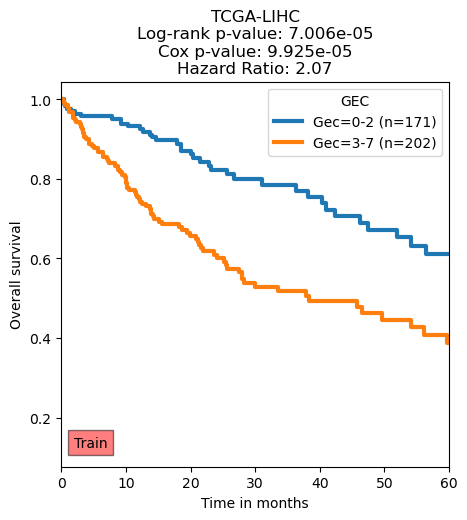

In [55]:
data_gec_bis = make_GEC_bis(expression_data_TCGA_LIHC, biomarqueur, seuil_ectopy)
clinic_data_TCGA_LIHC.loc[:, "Gec"] = data_gec_bis['Gec']

# Appel de la fonction surv_plot
surv_plot_bis(data_gec_bis, clinic_data_TCGA_LIHC, 'Gec','Train','red')

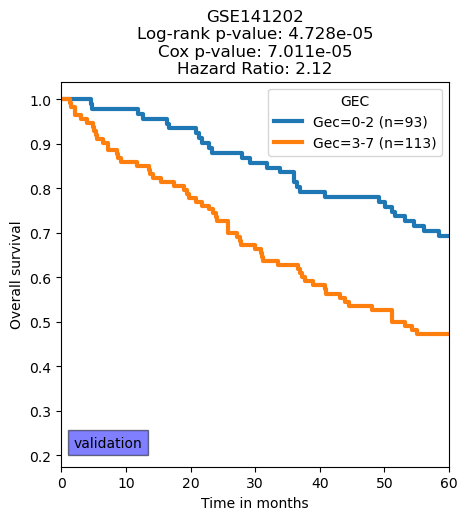

In [56]:
data_gec_bis = make_GEC_bis(expression_data_GSE141202, biomarqueur, seuil_ectopy)
clinic_data_GSE141202.loc[:, "Gec"] = data_gec_bis['Gec']

# Appel de la fonction surv_plot
surv_plot_bis(data_gec_bis, clinic_data_GSE141202, 'Gec','validation','blue')


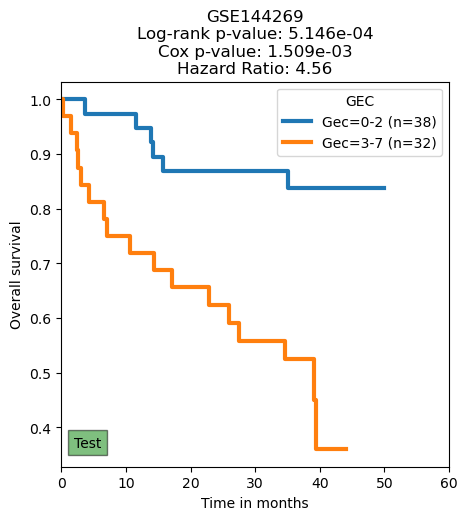

In [57]:
data_gec_bis = make_GEC_bis(expression_data_GSE144269, biomarqueur, seuil_ectopy)
clinic_data_GSE144269.loc[:, "Gec"] = data_gec_bis['Gec']

# Appel de la fonction surv_plot
surv_plot_bis(data_gec_bis, clinic_data_GSE144269, 'Gec','Test','green')
